# Instalação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns


import matplotlib.pyplot as plt
import math



## Bibliotecas de automação

In [2]:
#YData-Profiling (Antigo Pandas Profiling)
!pip install ydata-profiling -q

In [3]:
#SweetViz
!pip install sweetviz -q

### Configurações de exibição

In [4]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

# Funções

In [5]:
# Criar variável para metadados
# (nomes das colunas, tipos, quantidade de nulos, percentual de nulos, cardinalidade)

def generate_metadata(dataframe):
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os metadados serão gerados.
    :return: DataFrame contendo metadados.
    """

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinalidade': dataframe.nunique(),
    })

    metadata = metadata.reset_index(drop=True)

    return metadata

In [6]:
# Checagem de dados sujos
def checagem_de_valores_nulos(df, columns):
    dados_sujos = []

    for col in columns:
        # Tenta converter para número: o que for texto vira NaN (nulo)
        convertido = pd.to_numeric(df[col], errors='coerce')

        # Filtra o que era preenchido no original mas virou nulo na conversão
        selecao_suja = convertido.isna() & df[col].notna()

        # Coleta os valores únicos que causaram o erro
        amostra_suja = df.loc[selecao_suja, col].unique()

        for dado in amostra_suja:
            dados_sujos.append({'Coluna': col, 'Valor_Sujo': dado})

    return pd.DataFrame(dados_sujos)

In [7]:
def realizar_tipagem_dados(df):
    df_out = df.copy()

    # 1. Ajuste Específico para SAFRA (YYYYMM)
    # Converto para string, removo o ".0" (se houver) e somamos "01"
    if 'SAFRA' in df_out.columns:
        df_out['SAFRA'] = df_out['SAFRA'].astype(str).str.replace('.0', '', regex=False)
        df_out['SAFRA'] = pd.to_datetime(df_out['SAFRA'] + '01', format='%Y%m%d', errors='coerce')

    # 2. Outras DATAS
    cols_date = ['DATADENASCIMENTO', 'var_12', 'var_13', 'var_17']
    for col in cols_date:
        if col in df_out.columns:
            df_out[col] = pd.to_datetime(df_out[col], dayfirst=True, errors='coerce')

    # 3. INTEIROS (Flags e Alvos)
    cols_int = ['FLAG_INSTALACAO', 'FPD', 'var_14', 'var_16', 'FPD_SCORE']
    for col in cols_int:
        if col in df_out.columns:
            df_out[col] = pd.to_numeric(df_out[col], errors='coerce').fillna(0).astype(int)

    # 4. NUMÉRICOS (Floats)
    cols_num = ['var_03', 'var_04', 'var_05', 'var_06', 'var_07', 'var_08', 'var_09', 'var_11']
    for col in cols_num:
        if col in df_out.columns:
            df_out[col] = pd.to_numeric(df_out[col], errors='coerce')

    # 5. CATEGÓRICAS (Object)
    cols_obj = [
        'NUM_CPF', 'PROD', 'flag_mig2', 'STATUSRF', 'var_10', 'var_15',
        'var_18', 'var_19', 'var_20', 'var_21', 'var_22', 'var_23',
        'var_24', 'var_25', 'CEP_3_digitos', 'ID', 'var_02'
    ]
    for col in cols_obj:
        if col in df_out.columns:
            df_out[col] = df_out[col].astype(str)

    return df_out





In [8]:
def kdeplots_var_num_target(df, target, sample_size=100000):
    # 1. Filtra apenas colunas numéricas que REALMENTE variam
    cols_num = [col for col in df.select_dtypes(include=['float64', 'int64']).columns
                if df[col].nunique() > 1 and col != target]

    # Amostragem para performance
    df_plot = df.sample(min(len(df), sample_size)).copy()

    n_cols = 3
    n_rows = math.ceil(len(cols_num) / n_cols)
    plt.figure(figsize=(18, 4 * n_rows))

    for i, col in enumerate(cols_num, 1):
        plt.subplot(n_rows, n_cols, i)

        # Verificando se a amostra específica ainda tem variância para o plot
        if df_plot[col].nunique() > 1:
            sns.kdeplot(data=df_plot, x=col, hue=target, fill=True, common_norm=False)
            plt.title(f'{col} vs {target}')
        else:
            plt.text(0.5, 0.5, f'{col}\n(Variância Zero na Amostra)',
                     ha='center', va='center')

    plt.tight_layout()



In [9]:
def plot_cat_vs_target_percentage(df, target, cutoff=100):
    # Identifica categóricas com cardinalidade razoável
    cols_cat = [c for c in df.select_dtypes(include=['object', 'category']).columns
                if df[c].nunique() <= 30 and c != target]

    n_cols = 2
    n_rows = math.ceil(len(cols_cat) / n_cols)
    plt.figure(figsize=(16, 5 * n_rows))

    # Garantir que o target seja numérico (0 e 1)
    target_num = df[target].astype(int)
    media_geral = target_num.mean()

    for i, col in enumerate(cols_cat, 1):
        plt.subplot(n_rows, n_cols, i)

        # Filtra categorias com volume mínimo (cutoff)
        counts = df[col].value_counts()
        valid_cats = counts[counts > cutoff].index
        df_filtered = df[df[col].isin(valid_cats)].copy()
        df_filtered[target] = df_filtered[target].astype(int)

        # Calcula a taxa de FPD por categoria para ordenar
        res = df_filtered.groupby(col)[target].mean().sort_values(ascending=False)

        # Plot corrigido (hue=y para evitar o aviso e legend=False)
        sns.barplot(x=res.values, y=res.index, hue=res.index, palette='coolwarm', legend=False)

        # Linha da média geral da base (Benchmark)
        plt.axvline(media_geral, color='black', linestyle='--', label=f'Média Geral: {media_geral:.2%}')
        plt.title(f'Taxa de {target} por {col} (Frequência > {cutoff})')
        plt.xlabel(f'Proporção de {target}')
        plt.grid(axis='x', alpha=0.3)

    plt.tight_layout()



In [10]:

def analise_bivariada_temporal(df, col_data, target):
    df_temp = df.copy()

    # Criando uma coluna de Mes/Ano para agrupar (YYYY-MM)
    df_temp['mes_referencia'] = df_temp[col_data].dt.to_period('M').astype(str)

    # Calculando a taxa de FPD por mês
    # Convertemos FPD para int para calcular a média
    target_num = df_temp[target].astype(int)
    taxa_fpd = df_temp.groupby('mes_referencia')[target].apply(lambda x: x.astype(int).mean()) * 100

    # Plotando
    plt.figure(figsize=(15, 6))
    taxa_fpd.plot(kind='line', marker='o', color='darkblue', linewidth=2, markersize=8)

    # Linha da média geral para referência
    plt.axhline(target_num.mean() * 100, color='red', linestyle='--', label='Média Geral')

    plt.title(f'Taxa de Inadimplência (FPD) por Mês de {col_data}', fontsize=14)
    plt.ylabel('FPD (%)')
    plt.xlabel('Safra (Meses)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# Leitura da Base de Dados

## Lendo o Google Drive

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Primeiras Visualizações

In [12]:
df_base_dados_cadastrais = pd.read_parquet('/content/drive/MyDrive/HACKATHON 2026/base_dados_cadastrais/part-00000-8b686964-78fc-4d3e-8888-86eb4f12cb6b-c000.snappy.parquet')

In [13]:
df_base_dados_cadastrais.shape

(3900378, 33)

In [14]:
df_bdc = df_base_dados_cadastrais.copy()

In [15]:
df_bdc.head(20)

,NUM_CPF,SAFRA,FLAG_INSTALACAO,FPD,PROD,flag_mig2,STATUSRF,DATADENASCIMENTO,var_03,var_02,var_04,var_05,var_06,var_07,var_08,var_09,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,CEP_3_digitos
0,77789989YZZ,202503,1,0,CMV,PRE,REGULAR,09/09/1984,33,None,0,2,None,None,None,9,None,None,21/06/2017,None,None,None,None,None,None,AUX_EMRG,None,FUNC_PRIVADO,None,None,ADMITIDO,AUX_EMRG FUNC_PRIVADO,768
1,7778TYWXT9X,202412,1,0,CMV,Aquisição,REGULAR,16/08/1979,None,None,0,4,None,None,None,None,None,None,03/02/2016,None,1,None,None,None,None,None,None,FUNC_PRIVADO,EMPR/DIRETOR,None,ADMITIDO,FUNC_PRIVADO EMPR/DIRETOR,490
2,7778XUZNYU9,202410,1,0,CMV,PRE,REGULAR,23/07/1981,4,None,0,1,None,None,None,None,None,None,01/12/2019,01/11/2021,None,None,None,None,None,None,None,FUNC_PRIVADO,None,None,DISPENSADO,FUNC_PRIVADO,689
3,7778YY8WZZZ,202411,0,None,CMV,None,REGULAR,10/01/1976,48,None,0,3,None,None,None,8,None,None,15/10/2007,None,None,None,None,None,None,AUX_EMRG,None,FUNC_PRIVADO,None,None,ADMITIDO,AUX_EMRG FUNC_PRIVADO,934
4,7779TX8ZTXT,202410,1,1,CMV,Aquisição,REGULAR,24/02/1982,4,None,0,2,None,None,None,None,None,None,01/05/2020,01/12/2021,1,None,None,None,None,None,None,FUNC_PRIVADO,EMPR/DIRETOR,None,DISPENSADO,FUNC_PRIVADO EMPR/DIRETOR,455
5,7779XWW98YZ,202502,0,None,CMV,None,REGULAR,08/10/1952,33,None,1,3,1,2470.73,42,None,None,None,None,None,None,None,None,None,APOSENTADO,None,None,None,None,None,None,APOSENTADO,134
6,7779XWW98YZ,202503,1,0,CMV,Aquisição,REGULAR,08/10/1952,33,None,1,3,1,2470.73,42,None,None,None,None,None,None,None,None,None,APOSENTADO,None,None,None,None,None,None,APOSENTADO,134
7,7779ZY78YXT,202411,1,1,CMV,PRE,REGULAR,30/11/1982,33,None,0,1,None,None,None,None,None,None,06/05/2016,None,None,None,None,None,None,None,None,FUNC_PRIVADO,None,None,ADMITIDO,FUNC_PRIVADO,660
8,777N7NYU8YZ,202411,1,0,CMV,Aquisição,REGULAR,29/07/1957,None,None,0,2,1,1483.46,42,None,None,None,01/09/1980,None,None,None,None,None,APOSENTADO,None,None,FUNC_PRIVADO,None,None,ADMITIDO,APOSENTADO FUNC_PRIVADO,130
9,777NTUNZZWZ,202503,1,0,CMV,Aquisição,REGULAR,06/06/1942,1,None,0,2,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,981


In [16]:
df_bdc.tail(20)

,NUM_CPF,SAFRA,FLAG_INSTALACAO,FPD,PROD,flag_mig2,STATUSRF,DATADENASCIMENTO,var_03,var_02,var_04,var_05,var_06,var_07,var_08,var_09,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,CEP_3_digitos
3900358,ZZZZ9YN7Y8Z,202502,1,0,CMV,PRE,PENDENTE DE REGULARIZACAO,04/09/1990,None,None,0,3,None,None,None,None,None,None,19/03/2016,None,None,None,None,None,None,None,None,FUNC_PRIVADO,None,None,ADMITIDO,FUNC_PRIVADO,690
3900359,ZZZZNUZW79U,202412,1,1,CMV,Aquisição,PENDENTE DE REGULARIZACAO,14/06/1967,67,None,0,2,None,None,None,None,None,None,02/05/2002,None,None,None,None,None,None,None,None,FUNC_PRIVADO,None,None,ADMITIDO,FUNC_PRIVADO,285
3900360,ZZZZTNYXNT8,202412,0,None,CMV,None,REGULAR,19/01/1973,25,None,0,3,None,None,None,7,None,None,01/11/2011,None,None,None,None,None,None,AUX_EMRG,None,FUNC_PRIVADO,None,None,ADMITIDO,AUX_EMRG FUNC_PRIVADO,338
3900361,ZZZZTTXU7W8,202410,1,0,CMV,PRE,REGULAR,01/12/1967,2,None,0,1,None,None,None,8,None,None,None,None,None,None,None,None,None,AUX_EMRG,None,None,None,None,None,AUX_EMRG,247
3900362,ZZZZTZW878Y,202501,1,0,CMV,Aquisição,REGULAR,17/08/1955,33,None,0,1,1,983.99,32,None,None,None,None,None,None,None,None,None,APOSENTADO,None,None,None,None,None,None,APOSENTADO,247
3900363,ZZZZUTTTYZX,202411,0,None,CMV,None,REGULAR,26/06/1997,43,None,0,1,None,None,None,8,None,None,None,None,None,None,None,None,None,AUX_EMRG,None,None,None,None,None,AUX_EMRG,690
3900364,ZZZZUTTTYZX,202412,0,None,CMV,None,REGULAR,26/06/1997,43,None,0,1,None,None,None,8,None,None,None,None,None,None,None,None,None,AUX_EMRG,None,None,None,None,None,AUX_EMRG,690
3900365,ZZZZUW9T9YX,202410,1,0,CMV,Aquisição,REGULAR,11/10/1974,33,None,0,5,None,None,None,None,None,None,21/02/2000,None,None,None,None,None,None,None,None,FUNC_PRIVADO,None,None,ADMITIDO,FUNC_PRIVADO,884
3900366,ZZZZWXTWNYY,202412,1,0,CMV,PRE,REGULAR,02/03/1967,33,None,0,2,1,None,31,8,None,None,None,None,None,None,None,None,APOSENTADO,AUX_EMRG,None,None,None,None,None,APOSENTADO AUX_EMRG,340
3900367,ZZZZWYW7XWW,202411,1,0,CMV,PRE,REGULAR,28/06/1983,96,None,0,2,None,None,None,None,None,None,03/07/2019,None,None,None,None,None,None,None,None,FUNC_PRIVADO,None,None,ADMITIDO,FUNC_PRIVADO,725


In [17]:
df_bdc.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900378 entries, 0 to 3900377
Data columns (total 33 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   NUM_CPF           object
 1   SAFRA             object
 2   FLAG_INSTALACAO   object
 3   FPD               object
 4   PROD              object
 5   flag_mig2         object
 6   STATUSRF          object
 7   DATADENASCIMENTO  object
 8   var_03            object
 9   var_02            object
 10  var_04            object
 11  var_05            object
 12  var_06            object
 13  var_07            object
 14  var_08            object
 15  var_09            object
 16  var_10            object
 17  var_11            object
 18  var_12            object
 19  var_13            object
 20  var_14            object
 21  var_15            object
 22  var_16            object
 23  var_17            object
 24  var_18            object
 25  var_19            object
 26  var_20            object
 27  var_21      

In [18]:
nulos = df_bdc.isnull().sum()
print(nulos[nulos > 0])

FPD                 1203757
flag_mig2           1266478
STATUSRF              15154
DATADENASCIMENTO      16831
var_03               269970
var_02              3685278
var_04                15154
var_05               196424
var_06              3157126
var_07              3250748
var_08              3157325
var_09              2223690
var_10              3838163
var_11              3842389
var_12              1490335
var_13              3314097
var_14              3533608
var_15              3315375
var_16              3315375
var_17              3315375
var_18              3157126
var_19              2223690
var_20              3827574
var_21              1490335
var_22              3533608
var_23              3315375
var_24              1490335
var_25               467469
CEP_3_digitos        292051
dtype: int64


### Checando correspondência dos valores 'None' em FPD com a marcação 0 em 'FLAG_INSTALACAO'

In [19]:
# 1. Gerando o crosstab
validacao = pd.crosstab(
    df_bdc['FLAG_INSTALACAO'],
    df_bdc['FPD'].fillna('NULO'),
    margins=True
)

# 2. Aplicando formatação visual
# 'background_gradient' para destacar onde os dados estão concentrados
estilo_validacao = validacao.style.background_gradient(cmap='Blues') \
    .format("{:,}") \
    .set_caption("Validação de Regra de Negócio: Instalação vs FPD") \
    .set_properties(**{'text-align': 'center', 'border': '1px solid white'})

# Exibindo
estilo_validacao

FPD,0,1,NULO,All
FLAG_INSTALACAO,,,,
0,0,0,"1,203,757","1,203,757"
1,"2,122,991","573,630",0,"2,696,621"
All,"2,122,991","573,630","1,203,757","3,900,378"


## Insights 1:



1. A coluna 'FPD' (First Payment Default) contém valores 'None' que  coincidem com os valores 0 na flag_instalação. Não há nulos de outra forma.
2. Da coluna 'var_18' a coluna 'var_24' são valores categóricos com informações sobre os tipos de renda, cargo e afins. 'var_25' contém um valor com essas características agrupadas.
3. Além das colunas 'var' temos as seguintes colunas:
   
    * NUM_CPF = 	Número de CPF anonimizado do cliente. Usado como identificador único.
   
    * SAFRA	= Período de referência da observação no formato AAAAMM (Ano Mês).
   
    * FLAG_INSTALACAO = Formada por 1 e 0, sendo provavelmente uma flag para instalado ou não
   
    *	FPD = É o Target do problema. Indicador de First Payment Default (Primeira Inadimplência). 1 para inadimplente, 0 para adimplente.
   
    *	PROD = Aparenta ter 3 valores categóricos 'CMV', 'DTH' e 'NET'. Baseado no nome da coluna, suponho que sejam produtos.
   
    *	flag_mig2 = Alterna entre Aquisição e PRE, além dos valores None. Necessita mais investigação.
   
    *	STATUSRF = categóricas REGULAR e PENDENTE DE REGULARIZAÇÃO. Investigar se existem outras.
   
    *	DATADENASCIMENTO = Data de nascimento no formato DD/MM/AAAA
    
4. Todas as colunas estão categorizadas como object.
 * Minha sugestão:
    * NUM_CPF / object
    * SAFRA	/ datetime
    * FLAG_INSTALACAO	/ int64
    * FPD	/ int64
    * PROD	/ object
    * flag_mig2	/ object
    * STATUSRF	/ object
    * DATADENASCIMENTO	/ datetime
    * De var_03	a var_11	/ int64 ou float64
    * var_12	e var_13	/datetime
    * var_14	/ int64
    * var_15 / object
    * var_16 / int
    * var_17 / datetime
    * var 18 a var_25	/ object
    * CEP_3_digitos
  


## Gerando metadados

In [20]:
metadados_bdc = generate_metadata(df_bdc)
display(metadados_bdc)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,NUM_CPF,object,0,0.00,3590459
1,SAFRA,object,0,0.00,6
2,FLAG_INSTALACAO,object,0,0.00,2
3,FPD,object,1203757,30.86,2
4,PROD,object,0,0.00,3
5,flag_mig2,object,1266478,32.47,3
6,STATUSRF,object,15154,0.39,6
7,DATADENASCIMENTO,object,16831,0.43,30046
8,var_03,object,269970,6.92,100
9,var_02,object,3685278,94.49,2130


##Insights 2:

A presença de nulos é massiva no dataset, porém ao analisar os valores 'None' na coluna 'FPD' constatei que são referentes aos valores 0 (não instalados) da coluna 'FLAG_INSTALAÇÃO'.

Visto que esses valores nulos podem ter motivos claros se observados com atenção, cabe análise de quais variáveis serão analisadas a fundo.

## Verificando duplicadas

In [21]:
num_duplicadas = df_bdc.duplicated().sum()
print(f"Número de linhas duplicadas: {num_duplicadas}")

Número de linhas duplicadas: 0


# Lendo o dataset Bureau

(Para conectar as 2 tabelas e analisar somentes os clientes que estão no escopo do projeto)

In [22]:
df_bureal = pd.read_parquet('/content/drive/MyDrive/HACKATHON 2026/base_score_bureau_movel/part-00000-b6bf6bdd-9a2d-4bc5-a97c-fa8553906bc9-c000.snappy.parquet')

In [23]:
df_bureal.shape

(1290526, 8)

In [24]:
df_bureal.head()

,SAFRA,FLAG_INSTALACAO,FPD,PROD,flag_mig2,SCORE_01,SCORE_02,NUM_CPF
0,202410,1,0,CMV,PRE,562,636,ZZZZZX7XWY8
1,202410,1,1,CMV,PRE,546,518,ZZZZZX88YXY
2,202410,1,0,CMV,PRE,621,750,ZZZZZYT7XYT
3,202410,1,1,CMV,PRE,609,679,ZZZZZNTXY9Z
4,202410,1,0,CMV,PRE,621,722,ZZZZZ79ZXUX


In [25]:
#renomeando coluna FPD para enviar devido join:
df_bureal.rename(columns={'FPD': 'FPD_SCORE'}, inplace=True)
#olhando algumas linhas da tabela:
df_bureal.head(5)

,SAFRA,FLAG_INSTALACAO,FPD_SCORE,PROD,flag_mig2,SCORE_01,SCORE_02,NUM_CPF
0,202410,1,0,CMV,PRE,562,636,ZZZZZX7XWY8
1,202410,1,1,CMV,PRE,546,518,ZZZZZX88YXY
2,202410,1,0,CMV,PRE,621,750,ZZZZZYT7XYT
3,202410,1,1,CMV,PRE,609,679,ZZZZZNTXY9Z
4,202410,1,0,CMV,PRE,621,722,ZZZZZ79ZXUX


In [26]:
#CRIAR ID DE CONEXÃO ENTRE AS TABELAS:
df_bureal['ID'] = df_bureal['NUM_CPF'].astype(str) + '_' + df_bureal['SAFRA'].astype(str)
df_bdc['ID'] = df_bdc['NUM_CPF'].astype(str) + '_' + df_bdc['SAFRA'].astype(str)

In [27]:
#Trazendo a informação do fpd da tabela score para tabela telco
df_bdc = df_bdc.merge(df_bureal[['ID', 'FPD_SCORE']], on='ID', how='inner')
df_bdc.head(5)

,NUM_CPF,SAFRA,FLAG_INSTALACAO,FPD,PROD,flag_mig2,STATUSRF,DATADENASCIMENTO,var_03,var_02,var_04,var_05,var_06,var_07,var_08,var_09,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,CEP_3_digitos,ID,FPD_SCORE
0,77789989YZZ,202503,1,0,CMV,PRE,REGULAR,09/09/1984,33,None,0,2,None,None,None,9,None,None,21/06/2017,None,None,None,None,None,None,AUX_EMRG,None,FUNC_PRIVADO,None,None,ADMITIDO,AUX_EMRG FUNC_PRIVADO,768,77789989YZZ_202503,0
1,7778XUZNYU9,202410,1,0,CMV,PRE,REGULAR,23/07/1981,4,None,0,1,None,None,None,None,None,None,01/12/2019,01/11/2021,None,None,None,None,None,None,None,FUNC_PRIVADO,None,None,DISPENSADO,FUNC_PRIVADO,689,7778XUZNYU9_202410,0
2,7779ZY78YXT,202411,1,1,CMV,PRE,REGULAR,30/11/1982,33,None,0,1,None,None,None,None,None,None,06/05/2016,None,None,None,None,None,None,None,None,FUNC_PRIVADO,None,None,ADMITIDO,FUNC_PRIVADO,660,7779ZY78YXT_202411,1
3,777TW8879ZU,202410,1,1,CMV,PRE,REGULAR,26/12/1969,10,None,0,2,None,None,None,9,None,None,25/09/2017,None,None,None,None,None,None,AUX_EMRG,None,FUNC_PRIVADO,None,None,ADMITIDO,AUX_EMRG FUNC_PRIVADO,890,777TW8879ZU_202410,1
4,777U8UTZYZZ,202412,1,0,CMV,PRE,REGULAR,17/04/1985,33,None,0,1,None,None,None,9,None,None,01/07/2008,None,None,AM,800,202311,None,AUX_EMRG,None,FUNC_PRIVADO,None,BOLSA_FAMILIA,ADMITIDO,AUX_EMRG FUNC_PRIVADO BOLSA_FAMILIA,691,777U8UTZYZZ_202412,0


In [28]:
df_bdc.shape

(1290526, 35)

# EDA com Bibliotecas de Automação

## Ydata Profile

In [29]:
#from ydata_profiling import ProfileReport

# Gerando o relatório para uma amostra de 100k linhas (mais seguro para o Colab)
# Se quiser o dataset todo, remova o .sample(100000)
#profile = ProfileReport(df_bdc.sample(100000), title="Profiling BDC - Bureau", explorative=True)

# Exibir dentro do notebook
#profile.to_notebook_iframe()

# Salvar como arquivo HTML para baixar (recomendado)
#profile.to_file("relatorio_bdc.html")

In [30]:
#profile.to_file("meu_relatorio.html")

## Sweet Viz

In [31]:

#import sweetviz as sv


#feature_config = sv.FeatureConfig(
    #force_cat=['CEP_3_digitos', 'FPD_SCORE'], # Força o score e o cep como categorias
    #skip=['ID'] # Pular o ID, pois ele não gera estatística (é único por linha)
#)

#df_eda = df_bdc.sample(100000).copy()
#df_eda['FPD'] = pd.to_numeric(df_eda['FPD'], errors='coerce').fillna(0).astype(int)
#df_eda['FPD_SCORE'] = pd.to_numeric(df_eda['FPD_SCORE'], errors='coerce').fillna(0).astype(int)

# Rodando com a configuração especial
#report = sv.analyze(
#    df_eda,
#    target_feat='FPD',
#    feat_cfg=feature_config
#)

#sweet_report = sv.analyze(df_bureal)
#sweet_report = sv.analyze(df_eda, target_feat = 'FPD')
#sweet_report.show_html('sweetviz_df_bdc.html')

### Análise da heatmap SweetViz via I.A


 * **Target (FPD):** A base apresenta um desbalanceamento de aproximadamente 80/20 (Adimplentes vs. Inadimplentes). Será necessário considerar técnicas de balanceamento (como pesos de classe) durante o treinamento.

 * **Aderência do Bureau (FPD_SCORE):** A correlação de 1.0 no mapa de associações indica que, nesta amostra, o FPD_SCORE é idêntico ao FPD. Era o esperado deido ao inner join.

 * **Multicolinearidade Identificada:** As variáveis FLAG_INSTALACAO, PROD, flag_mig2 e STATUSRF possuem altíssima correlação entre si (o bloco azul sólido no Heatmap).

 * **Visão Temporal (Safra):** A linha de tendência na variável SAFRA indica oscilações na taxa de inadimplência entre os períodos. Isso sugere que a "safra" é um componente de risco relevante e deve ser tratada como variável categórica ou ordinal.

 * **Fidelidade do Dado (ID):** A cardinalidade superior a 99% no NUM_CPF confirma que a unidade de análise é o CPF único por período, validando a estrutura de CPF_SAFRA.

 * **Variável var_25:** Apresenta forte associação com múltiplas variáveis do dataset. Deve ser investigada para entender se é um dado agregado ou um somatório de outros campos.

# Checagem de Qualidade dos Dados

In [32]:
df_bdc.shape

(1290526, 35)

In [33]:
generate_metadata(df_bdc)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,NUM_CPF,object,0,0.00,1272095
1,SAFRA,object,0,0.00,6
2,FLAG_INSTALACAO,object,0,0.00,1
3,FPD,object,0,0.00,2
4,PROD,object,0,0.00,1
5,flag_mig2,object,0,0.00,1
6,STATUSRF,object,1439,0.11,5
7,DATADENASCIMENTO,object,1912,0.15,26478
8,var_03,object,84782,6.57,100
9,var_02,object,1218575,94.42,1668


## Insights:


 * Todas as colunas são object
 * A coluna NUM_CPF tem cardinalidade menor que a FPD_SCORE, indicando a presença de cpf duplicados (Provavelmente contratos em safras diferentes, como visto previamente)
 * Muitas colunas "var.." apresentam nulos acima de 50%

### Insights I.A:

 * **Identificadores e Chaves:** A coluna NUM_CPF apresenta cardinalidade de 99,8%, confirmando a granularidade de nível CPF por safra.

 * **Vacância Crítica (Nulos > 80%):** As variáveis var_02, var_10, var_11, var_14, var_20 e var_22 apresentam volume de dados nulos superior a 80%, tornando-as estatisticamente irrelevantes para generalização.

 * **Sazonalidade (Safra):** A variável SAFRA apresenta 6 níveis distintos e variação na taxa de inadimplência média por período, sugerindo impacto temporal no risco.

 * **Dados Cadastrais:** As colunas DATADENASCIMENTO e STATUSRF possuem excelente completitude (menos de 0.2% de nulos).

 * **Localização (CEP):** A variável CEP_3_digitos possui 5.94% de valores ausentes e uma cardinalidade de 901 categorias, indicando alta fragmentação geográfica.

#Criando uma copy para transformar tipos

In [34]:
df_bdc_alt = df_bdc.copy()

#Alterando tipos do dataset

## Sugestão de Tipagem de Dados (df_bdc_alt)


**Identificadores e Categorias (object):**

 * **Variáveis:** NUM_CPF, PROD, flag_mig2, STATUSRF, var_10, var_15, var_18 a var_25 e CEP_3_digitos.

   - Por que: São colunas que representam etiquetas ou categorias. Manter como object (string) evita que o modelo tente realizar cálculos com números que são códigos ou regiões (como o CEP).

**Marcos Temporais (datetime):**

 * Variáveis: SAFRA, DATADENASCIMENTO, var_12 e var_13

   - Por que: Como essas colunas representam datas, estão sendo convertidas para futuras análises temporais.

**Indicadores Binários e Contagens (int64):**

 * Variáveis: FLAG_INSTALACAO, FPD, var_14 e var_16.

   - Por que: São variáveis binárias (0 ou 1).

**Escalas Numéricas e Scores (float64 / int64):**

 * Variáveis: var_03 a var_09 e var_11.

   - Por que: São variáveis quantitativas que representam grandezas (valores financeiros, scores ou quantidades).

##Checagem de Valores Sujos

In [35]:
# 1. Colunas Numéricas para validar
colunas_para_validar = [
    'var_03', 'var_04', 'var_05', 'var_06', 'var_07', 'var_08',
    'var_09', 'var_11', 'var_14', 'var_16',
    'FLAG_INSTALACAO', 'FPD', 'FPD_SCORE'
]

# 2. Execução da Auditoria na Base Inteira
df_auditoria = checagem_de_valores_nulos(df_bdc_alt, colunas_para_validar)

# 3. Trava de Segurança: Só agrupa se houver dados sujos
if not df_auditoria.empty:
    relatorio_sujeira = df_auditoria.groupby(['Coluna', 'Valor_Sujo']).size().reset_index(name='Frequencia')
    display(relatorio_sujeira.sort_values(by='Frequencia', ascending=False).head(20))
else:
    print("✅ Sucesso: Nenhum valor sujo encontrado! Todas as colunas estão prontas para conversão numérica.")

✅ Sucesso: Nenhum valor sujo encontrado! Todas as colunas estão prontas para conversão numérica.


##Transformando

In [36]:
# Execução
df_bdc_alt = realizar_tipagem_dados(df_bdc_alt)

/tmp/ipython-input-825691344.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_out[col] = pd.to_datetime(df_out[col], dayfirst=True, errors='coerce')


In [37]:
df_bdc_alt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1290526 entries, 0 to 1290525
Data columns (total 35 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   NUM_CPF           1290526 non-null  object        
 1   SAFRA             1290526 non-null  datetime64[ns]
 2   FLAG_INSTALACAO   1290526 non-null  int64         
 3   FPD               1290526 non-null  int64         
 4   PROD              1290526 non-null  object        
 5   flag_mig2         1290526 non-null  object        
 6   STATUSRF          1290526 non-null  object        
 7   DATADENASCIMENTO  1288614 non-null  datetime64[ns]
 8   var_03            1205744 non-null  float64       
 9   var_02            1290526 non-null  object        
 10  var_04            1289087 non-null  float64       
 11  var_05            1235623 non-null  float64       
 12  var_06            246980 non-null   float64       
 13  var_07            215201 non-null   float6

In [38]:
generate_metadata(df_bdc_alt)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,NUM_CPF,object,0,0.00,1272095
1,SAFRA,datetime64[ns],0,0.00,6
2,FLAG_INSTALACAO,int64,0,0.00,1
3,FPD,int64,0,0.00,2
4,PROD,object,0,0.00,1
5,flag_mig2,object,0,0.00,1
6,STATUSRF,object,0,0.00,6
7,DATADENASCIMENTO,datetime64[ns],1912,0.15,26478
8,var_03,float64,84782,6.57,100
9,var_02,object,0,0.00,1669


##Investigando Duplicados

###Tabela com Duplicados

In [39]:
# 1. Linhas 100% idênticas (mesmo CPF, mesma Safra, mesma Variável)
duplicatas_exatas = df_bdc_alt.duplicated().sum()

# 2. CPFs que aparecem mais de uma vez
cpfs_duplicados = df_bdc_alt.duplicated(subset=['NUM_CPF']).sum()

# 3. Criando um DF para analisar QUEM são esses CPFs e se os dados mudam entre as aparições
analise_cpfs = df_bdc_alt[df_bdc_alt.duplicated(subset=['NUM_CPF'], keep=False)].sort_values(by='NUM_CPF')

print(f"Linhas totalmente idênticas: {duplicatas_exatas}")
print(f"CPFs repetidos na base: {cpfs_duplicados}")

# Visualizar os primeiros casos de CPFs repetidos para entender o comportamento
analise_cpfs[['NUM_CPF', 'SAFRA', 'FPD', 'FPD_SCORE']].head(10)

Linhas totalmente idênticas: 0
CPFs repetidos na base: 18431


,NUM_CPF,SAFRA,FPD,FPD_SCORE
972560,77778ZU9Y87,2024-11-01,1,1
972559,77778ZU9Y87,2024-12-01,0,0
1207537,777T8X88Z87,2024-12-01,0,0
1207538,777T8X88Z87,2025-01-01,0,0
268580,777W777N8WU,2024-11-01,0,0
268581,777W777N8WU,2025-01-01,1,1
637509,777W8ZZUXWU,2024-10-01,0,0
637508,777W8ZZUXWU,2025-03-01,0,0
838266,777XUY9NNXT,2025-03-01,0,0
838265,777XUY9NNXT,2024-12-01,1,1


### Contagem de cpfs e e frequência de repetição

In [40]:
# Contagem de aparições por CPF
contagem_aparições = df_bdc_alt['NUM_CPF'].value_counts()

# Criando um resumo da frequência
resumo_duplicidade = contagem_aparições.value_counts().sort_index()

print("Frequência de aparições dos CPFs na base:")
print(resumo_duplicidade)

# Identificar se há alguém com um número exagerado de linhas (ex: 12 safras)
display(contagem_aparições.head(5))

Frequência de aparições dos CPFs na base:
count
1    1254147
2      17481
3        452
4         14
5          1
Name: count, dtype: int64


,count
NUM_CPF,
ZW9TYZXTWTZ,5
ZW7UTZZYYW7,4
Z9XN9ZZWU7T,4
Z8Y88ZX77ZW,4
XUWNXZXN7ZU,4


### Checagem se alguma safra se repete

In [41]:
# Agrupando para comparar contagem de linhas vs contagem de safras únicas
cpf_safra_check = df_bdc_alt.groupby('NUM_CPF').agg(
    total_linhas=('SAFRA', 'count'),
    safras_unicas=('SAFRA', 'nunique')
).reset_index()

# Identificando onde a contagem de linhas é maior que a de safras
duplicados_mesmo_mes = cpf_safra_check[cpf_safra_check['total_linhas'] > cpf_safra_check['safras_unicas']]

print(f"Quantidade de CPFs com duplicidade no mesmo período: {len(duplicados_mesmo_mes)}")

if len(duplicados_mesmo_mes) > 0:
    print("\nExemplo desses casos:")
    display(duplicados_mesmo_mes.head())

Quantidade de CPFs com duplicidade no mesmo período: 0


### Filtrando dulicados para entender melhor

In [42]:
# 1. Identificar CPFs que aparecem em mais de uma SAFRA única
check_recorrencia = df_bdc_alt.groupby('NUM_CPF')['SAFRA'].nunique().reset_index()
cpfs_recorrentes = check_recorrencia[check_recorrencia['SAFRA'] > 1]['NUM_CPF'].head(4).tolist()

# 2. Filtrar e exibir os dados completos desses 4 CPFs específicos
for cpf in cpfs_recorrentes:
    print(f"\n" + "="*50)
    print(f"🔍 INVESTIGANDO JORNADA DO CPF: {cpf}")
    print("="*50)

    # Filtramos e ordenamos pela SAFRA para ver a evolução temporal
    df_temp = df_bdc_alt[df_bdc_alt['NUM_CPF'] == cpf].sort_values(by='SAFRA')

    print(f"Este cliente aparece em {len(df_temp)} safras diferentes.")
    display(df_temp)


🔍 INVESTIGANDO JORNADA DO CPF: 77778ZU9Y87
Este cliente aparece em 2 safras diferentes.


,NUM_CPF,SAFRA,FLAG_INSTALACAO,FPD,PROD,flag_mig2,STATUSRF,DATADENASCIMENTO,var_03,var_02,var_04,var_05,var_06,var_07,var_08,var_09,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,CEP_3_digitos,ID,FPD_SCORE
972560,77778ZU9Y87,2024-11-01,1,1,CMV,PRE,REGULAR,1985-01-14,33.00,None,0.00,1.00,NaN,NaN,NaN,9.00,None,NaN,2008-03-01,NaT,0,AC,355,NaT,None,AUX_EMRG,None,FUNC_PRIVADO,None,BOLSA_FAMILIA,ADMITIDO,AUX_EMRG FUNC_PRIVADO BOLSA_FAMILIA,699,77778ZU9Y87_202411,1
972559,77778ZU9Y87,2024-12-01,1,0,CMV,PRE,REGULAR,1985-01-14,33.00,None,0.00,1.00,NaN,NaN,NaN,9.00,None,NaN,2008-03-01,NaT,0,AC,355,NaT,None,AUX_EMRG,None,FUNC_PRIVADO,None,BOLSA_FAMILIA,ADMITIDO,AUX_EMRG FUNC_PRIVADO BOLSA_FAMILIA,699,77778ZU9Y87_202412,0



🔍 INVESTIGANDO JORNADA DO CPF: 777T8X88Z87
Este cliente aparece em 2 safras diferentes.


,NUM_CPF,SAFRA,FLAG_INSTALACAO,FPD,PROD,flag_mig2,STATUSRF,DATADENASCIMENTO,var_03,var_02,var_04,var_05,var_06,var_07,var_08,var_09,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,CEP_3_digitos,ID,FPD_SCORE
1207537,777T8X88Z87,2024-12-01,1,0,CMV,PRE,REGULAR,1975-03-21,17.00,None,0.00,2.00,NaN,NaN,NaN,9.00,None,NaN,2014-02-14,NaT,1,None,0,NaT,None,AUX_EMRG,None,FUNC_PRIVADO,EMPR/DIRETOR,None,DISPENSADO,AUX_EMRG FUNC_PRIVADO EMPR/DIRETOR,960,777T8X88Z87_202412,0
1207538,777T8X88Z87,2025-01-01,1,0,CMV,PRE,REGULAR,1975-03-21,17.00,None,0.00,2.00,NaN,NaN,NaN,9.00,None,NaN,2014-02-14,NaT,1,None,0,NaT,None,AUX_EMRG,None,FUNC_PRIVADO,EMPR/DIRETOR,None,DISPENSADO,AUX_EMRG FUNC_PRIVADO EMPR/DIRETOR,960,777T8X88Z87_202501,0



🔍 INVESTIGANDO JORNADA DO CPF: 777W777N8WU
Este cliente aparece em 2 safras diferentes.


,NUM_CPF,SAFRA,FLAG_INSTALACAO,FPD,PROD,flag_mig2,STATUSRF,DATADENASCIMENTO,var_03,var_02,var_04,var_05,var_06,var_07,var_08,var_09,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,CEP_3_digitos,ID,FPD_SCORE
268580,777W777N8WU,2024-11-01,1,0,CMV,PRE,REGULAR,1956-08-06,47.00,None,1.00,2.00,1.00,1892.83,42.00,NaN,None,NaN,NaT,NaT,0,None,0,NaT,APOSENTADO,None,None,None,None,None,None,APOSENTADO,136,777W777N8WU_202411,0
268581,777W777N8WU,2025-01-01,1,1,CMV,PRE,REGULAR,1956-08-06,47.00,None,1.00,2.00,1.00,1892.83,42.00,NaN,None,NaN,NaT,NaT,0,None,0,NaT,APOSENTADO,None,None,None,None,None,None,APOSENTADO,136,777W777N8WU_202501,1



🔍 INVESTIGANDO JORNADA DO CPF: 777W8ZZUXWU
Este cliente aparece em 2 safras diferentes.


,NUM_CPF,SAFRA,FLAG_INSTALACAO,FPD,PROD,flag_mig2,STATUSRF,DATADENASCIMENTO,var_03,var_02,var_04,var_05,var_06,var_07,var_08,var_09,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,CEP_3_digitos,ID,FPD_SCORE
637509,777W8ZZUXWU,2024-10-01,1,0,CMV,PRE,REGULAR,1969-05-24,4.00,None,0.00,2.00,NaN,NaN,NaN,NaN,None,NaN,2018-11-01,NaT,0,None,0,NaT,None,None,None,FUNC_PRIVADO,None,None,ADMITIDO,FUNC_PRIVADO,757,777W8ZZUXWU_202410,0
637508,777W8ZZUXWU,2025-03-01,1,0,CMV,PRE,REGULAR,1969-05-24,4.00,None,0.00,2.00,NaN,NaN,NaN,NaN,None,NaN,2018-11-01,NaT,0,None,0,NaT,None,None,None,FUNC_PRIVADO,None,None,ADMITIDO,FUNC_PRIVADO,757,777W8ZZUXWU_202503,0


### Investigando se há alguma variação entre safras nos contratos dos cpfs que se repetem

In [43]:
# 1. Pegamos apenas os CPFs que aparecem em mais de uma safra
contagem = df_bdc_alt['NUM_CPF'].value_counts()
cpfs_repetidos = contagem[contagem > 1].index
df_estudo = df_bdc_alt[df_bdc_alt['NUM_CPF'].isin(cpfs_repetidos)]

# 2. Vamos analisar as variáveis (excluindo o que é ID ou o próprio CPF)
cols_para_conferir = [c for c in df_bdc_alt.columns if c not in ['NUM_CPF', 'SAFRA', 'ID']]

# 3. Para cada CPF, vamos contar quantos valores DIFERENTES existem em cada coluna
# Se o cliente apareceu 2 vezes e nunique() for 1, o dado é IGUAL.
# Se nunique() for 2, o dado MUDOU.
variacao = df_estudo.groupby('NUM_CPF')[cols_para_conferir].nunique()

# 4. Agora, contamos em quantos CPFs essa variação foi maior que 1 (ou seja, mudou)
resumo_mudancas = (variacao > 1).sum().reset_index()
resumo_mudancas.columns = ['Variavel', 'Qtd_CPFs_que_mudaram']

# Adicionando a porcentagem para facilitar a leitura
total_recorrentes = len(variacao)
resumo_mudancas['%_de_mudanca'] = (resumo_mudancas['Qtd_CPFs_que_mudaram'] / total_recorrentes) * 100

print(f"Total de CPFs analisados (que se repetem): {total_recorrentes}")
display(resumo_mudancas.sort_values(by='%_de_mudanca', ascending=False))

Total de CPFs analisados (que se repetem): 17948


,Variavel,Qtd_CPFs_que_mudaram,%_de_mudanca
1,FPD,5841,32.54
31,FPD_SCORE,5841,32.54
28,var_24,1316,7.33
20,var_16,872,4.86
16,var_12,706,3.93
29,var_25,197,1.10
19,var_15,189,1.05
27,var_23,176,0.98
4,STATUSRF,76,0.42
18,var_14,29,0.16


###
  * A repetição de cpfs se deve ao mesmo cliente aparecendo em safras diferentes
  * Não existe nenhum cpf que se repita com a mesma Safra
  * Alguns cpfs tem contrato em até 4 safras, tendo um indivíduo com 5 contratos
  * Usar a última safra nesses casos pode ser o mais indicado
  * Há poucas mudanças relativas nas variáveis dos cpfs que se repetem entre as safras, mas variáveis específicas como o fpd, var_24 e var_16 tem uma porcentagem de mudança.

     - Insights I.A:
     
     
     - **A Estaticidade Quase Total:**
     
     De var_02 até a var_11, passando por PROD, CEP e DATADENASCIMENTO, a variação é 0% (ou próxima de zero).

     **Conclusão:**
     
      Essas variáveis são puramente cadastrais. Elas não mudam. Se o cliente pedir crédito hoje ou daqui a 6 meses, o sistema vai ler exatamente a mesma informação para esses campos.

     - **Mudanças com maior porcentagem  (var_24 e var_16):**
     
     A var_24 mudou para 7,33% dos clientes recorrentes e a var_16 para 4,86%.

     **Conclusão:**
     
     Essas são as variáveis mais "vivas". Elas provavelmente capturam algo que flutua mês a mês (talvez saldo em conta, limite utilizado ou alguma pontuação de comportamento recente).


     - **As var_25 e var_15 (aprox. 1%):**
     
      Apresentam uma mudança muito sutil. Pode indicar atualizações.

# Investigando Nulos

In [44]:
generate_metadata(df_bdc_alt)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,NUM_CPF,object,0,0.00,1272095
1,SAFRA,datetime64[ns],0,0.00,6
2,FLAG_INSTALACAO,int64,0,0.00,1
3,FPD,int64,0,0.00,2
4,PROD,object,0,0.00,1
5,flag_mig2,object,0,0.00,1
6,STATUSRF,object,0,0.00,6
7,DATADENASCIMENTO,datetime64[ns],1912,0.15,26478
8,var_03,float64,84782,6.57,100
9,var_02,object,0,0.00,1669


##Checando nulos das colunas datetime

In [45]:
# 1. Lista das colunas datetimecom nulos
cols_date = ['DATADENASCIMENTO', 'var_12', 'var_13', 'var_17']

# 2. Criando o diagnóstico específico
df_datetime_nulos = pd.DataFrame({
    'Qtd_Nulos': df_bdc_alt[cols_date].isnull().sum(),
    '%_Nulos': (df_bdc_alt[cols_date].isnull().sum() / len(df_bdc_alt)) * 100,
    'Min_Data': df_bdc_alt[cols_date].min(),
    'Max_Data': df_bdc_alt[cols_date].max()
})

print("=== DIAGNÓSTICO DE COLUNAS DATETIME ===")
display(df_datetime_nulos.sort_values(by='%_Nulos', ascending=False))

=== DIAGNÓSTICO DE COLUNAS DATETIME ===


,Qtd_Nulos,%_Nulos,Min_Data,Max_Data
var_17,1290526,100.00,NaT,NaT
var_13,1142019,88.49,2017-01-10,2021-12-31
var_12,496354,38.46,1957-07-30,2021-03-08
DATADENASCIMENTO,1912,0.15,1900-01-01,2015-08-15


### Insights I.A:
 1. **Coluna var_17**
    
    Com 100% de nulos. Ela ocupa espaço na memória, mas não oferece informação. Analisar possibilidade de descarte.

2. **O Hiato Temporal das variáveis var_12 e var_13**


    Sua SAFRA (momento da venda/análise) vai de Outubro/2024 a Março/2025.

    A data máxima da var_13 é Dezembro/2021.

    A data máxima da var_12 é Março/2021.

    **Conclusão:** Essas variáveis tratam de eventos que aconteceram há pelo menos 3 anos antes da concessão do crédito atual. Se elas representam "última negativação" ou "última consulta", a base está nos dizendo que o comportamento recente (dos últimos 3 anos) não está registrado nessas colunas específicas.

3. **Inconsistência na DATADENASCIMENTO**

    **Mínimo (1900-01-01):** Provavelmente um valor padrão (default) do sistema para quando não sabem a data real. Clientes com 125 anos são raros.

    **Máximo (2015-08-15):** Se a safra é 2024, um cliente nascido em 2015 teria apenas 9 anos. Isso indica que há CPFs de menores de idade ou erros de preenchimento.

## Checagem Datas de Nascimento Nulos

VIsualização:

In [46]:
# Filtramos especificamente onde DATADENASCIMENTO é nulo
filtro_nascimento_nulo = df_bdc_alt['DATADENASCIMENTO'].isnull()

print(f"Exibindo amostra dos {df_bdc_alt[filtro_nascimento_nulo].shape[0]} casos onde a Data de Nascimento é Nula:")

# Exibimos as colunas datetime para ver se os outros campos também estão nulos nesses casos
cols_datetime = ['NUM_CPF', 'SAFRA', 'DATADENASCIMENTO', 'var_12', 'var_13', 'var_17', 'FPD']

display(df_bdc_alt[filtro_nascimento_nulo][cols_datetime].head())

Exibindo amostra dos 1912 casos onde a Data de Nascimento é Nula:


,NUM_CPF,SAFRA,DATADENASCIMENTO,var_12,var_13,var_17,FPD
1135,7XWZUTNXXNZ,2024-11-01,NaT,NaT,NaT,NaT,0
1164,7XXYX8Y8YU8,2024-11-01,NaT,NaT,NaT,NaT,0
1166,7XXZ7ZXNYZ7,2024-11-01,NaT,NaT,NaT,NaT,1
1222,7XZN8N9YY8N,2024-10-01,NaT,NaT,NaT,NaT,1
1236,7XZUUYNZY7Z,2024-12-01,NaT,NaT,NaT,NaT,0


In [47]:
# 1. Identificar os CPFs sem data de nascimento
cpfs_sem_nascimento = df_bdc_alt[df_bdc_alt['DATADENASCIMENTO'].isnull()]['NUM_CPF'].unique()

# 2. Verificar quantos desses CPFs existem na base df_bureal

cpfs_no_bureal = df_bureal[df_bureal['NUM_CPF'].isin(cpfs_sem_nascimento)]['NUM_CPF'].unique()

# 3. Calcular quem está em uma mas não na outra
cpfs_ausentes_no_bureal = set(cpfs_sem_nascimento) - set(cpfs_no_bureal)

print(f"Total de CPFs sem Data de Nascimento: {len(cpfs_sem_nascimento)}")
print(f"Desses, quantos estão presentes no Bureau: {len(cpfs_no_bureal)}")
print(f"Desses, quantos NÃO existem no Bureau: {len(cpfs_ausentes_no_bureal)}")

# Proporção
percent_ausente = (len(cpfs_ausentes_no_bureal) / len(cpfs_sem_nascimento)) * 100
print(f"\nConclusão: {percent_ausente:.2f}% dos CPFs sem nascimento também não têm dados de bureau.")

Total de CPFs sem Data de Nascimento: 1900
Desses, quantos estão presentes no Bureau: 1900
Desses, quantos NÃO existem no Bureau: 0

Conclusão: 0.00% dos CPFs sem nascimento também não têm dados de bureau.


Relação dessas variáveis com o target

In [48]:
# 1. Criamos um marcador temporário para quem não tem data de nascimento
df_bdc_alt['tem_nascimento'] = df_bdc_alt['DATADENASCIMENTO'].notnull()

# 2. Comparamos o comportamento de quem tem vs quem não tem o dado
analise_grupo_nulo = df_bdc_alt.groupby('tem_nascimento').agg({
    'FPD': 'mean',           # Taxa de inadimplência
    'FPD_SCORE': 'mean',     # Bureau
    'NUM_CPF': 'count'       # Total de registros
}).reset_index()

# Convertendo FPD para porcentagem para facilitar leitura
analise_grupo_nulo['FPD'] = analise_grupo_nulo['FPD'] * 100

print("=== COMPARAÇÃO: CLIENTES COM VS SEM DATA DE NASCIMENTO ===")
display(analise_grupo_nulo)

=== COMPARAÇÃO: CLIENTES COM VS SEM DATA DE NASCIMENTO ===


,tem_nascimento,FPD,FPD_SCORE,NUM_CPF
0,False,43.99,0.44,1912
1,True,23.54,0.24,1288614


Insights:

* Os cpfs que ão contém data de nascimento também estão presentes no Bureau
* Existe um aumento da taxa dp FPD  em cpfs sem data de nascimento, mas esses valores representam apenas 0.15% da coluna

##Cpfs com Data de nascimento 1900

In [49]:
# Filtrando apenas os registros com a data de nascimento 'fóssil'
df_1900 = df_bdc_alt[df_bdc_alt['DATADENASCIMENTO'] == '1900-01-01']

# Selecionando colunas chave para a análise descritiva
cols_view = ['NUM_CPF', 'SAFRA', 'DATADENASCIMENTO', 'FPD', 'FLAG_INSTALACAO', 'FPD_SCORE', 'var_12', 'var_13']

print(f"Exibindo amostra das {len(df_1900)} linhas com data 1900-01-01:")
display(df_1900[cols_view].head(10))

Exibindo amostra das 2 linhas com data 1900-01-01:


,NUM_CPF,SAFRA,DATADENASCIMENTO,FPD,FLAG_INSTALACAO,FPD_SCORE,var_12,var_13
167733,ZZZ8Y8ZZ9NZ,2025-03-01,1900-01-01,0,1,0,NaT,NaT
1267116,ZTWUYXY9ZTY,2025-01-01,1900-01-01,0,1,0,2018-08-20,NaT


* São apenas dois valores com essa data de nascimento. Cabe análise do possível exclusão

## A coluna var_17 está 100% nula e a var_13 com 88%:

In [50]:
# 1. Head da var_17 (para confirmar que é tudo nulo/NaT)
print("--- Head da coluna var_17 (100% nulos) ---")
display(df_bdc_alt[['var_17']].head(1))

# 2. Head de valores NÃO NULOS da var_13
print("\n--- Head da coluna var_13 (Apenas valores preenchidos) ---")
display(df_bdc_alt[df_bdc_alt['var_13'].notnull()][['var_13']].head(5))

--- Head da coluna var_17 (100% nulos) ---


,var_17
0,NaT



--- Head da coluna var_13 (Apenas valores preenchidos) ---


,var_13
1,2021-11-01
6,2018-06-30
11,2021-11-03
30,2018-12-16
34,2018-10-20


## Checagem var_12

In [51]:


# 1. Criar um marcador: Tem Data vs Não Tem Data
df_bdc_alt['tem_var_12'] = df_bdc_alt['var_12'].notnull()

# 2. Comparar o comportamento de risco (FPD) e a recomendação do Bureau (FPD_SCORE)
analise_var_12 = df_bdc_alt.groupby('tem_var_12').agg({
    'FPD': 'mean',
    'FPD_SCORE': 'mean',
    'NUM_CPF': 'count'
}).reset_index()

# 3. Ver os valores mais frequentes (Top 5 datas)
top_datas_var_12 = df_bdc_alt['var_12'].value_counts().head(5)

print("=== ANÁLISE DE IMPACTO: var_12 ===")
display(analise_var_12)

print("\n=== TOP 5 DATAS MAIS FREQUENTES EM var_12 ===")
print(top_datas_var_12)

=== ANÁLISE DE IMPACTO: var_12 ===


,tem_var_12,FPD,FPD_SCORE,NUM_CPF
0,False,0.27,0.27,496354
1,True,0.21,0.21,794172



=== TOP 5 DATAS MAIS FREQUENTES EM var_12 ===
var_12
2019-10-01    2958
2019-04-01    2929
2020-02-03    2888
2019-08-01    2878
2019-02-01    2845
Name: count, dtype: int64


In [52]:
# Removendo as colunas de auxílio diagnóstico
df_bdc_alt = df_bdc_alt.drop(columns=['tem_nascimento', 'tem_var_12'])

print("Colunas removidas com sucesso. O dataset agora está limpo para a próxima etapa.")

Colunas removidas com sucesso. O dataset agora está limpo para a próxima etapa.


###
 * A var_12 contém datas mais antigas, com sua maioria entre 2019 e 2020
 * Os valores nulos das variáveis 'var_...' parecem ser em sua maioria dados faltantes ou ausencias de comportamento (Um cliente que não foi instalado, gera um dado ausente em uma variável comportamental que depende da instalação)

## Checagem valores nulos em colunas int e float

In [53]:
generate_metadata(df_bdc_alt)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,NUM_CPF,object,0,0.00,1272095
1,SAFRA,datetime64[ns],0,0.00,6
2,FLAG_INSTALACAO,int64,0,0.00,1
3,FPD,int64,0,0.00,2
4,PROD,object,0,0.00,1
5,flag_mig2,object,0,0.00,1
6,STATUSRF,object,0,0.00,6
7,DATADENASCIMENTO,datetime64[ns],1912,0.15,26478
8,var_03,float64,84782,6.57,100
9,var_02,object,0,0.00,1669


In [54]:
# Lista das colunas numéricas com nulos
cols_num_nulos = ['var_04', 'var_05', 'var_06', 'var_07', 'var_08', 'var_09', 'var_11']

resumo_impacto = []

for col in cols_num_nulos:
    # Agrupando por nulo vs não nulo para estatísticas de FPD
    stats = df_bdc_alt.groupby(df_bdc_alt[col].isnull()).agg({
        'FPD': 'mean',
        'NUM_CPF': 'count'
    })

    # Calculando a cardinalidade (valores únicos) apenas para os dados existentes
    cardinalidade = df_bdc_alt[col].nunique()

    resumo_impacto.append({
        'Variável': col,
        'Cardinalidade': cardinalidade,
        'FPD_se_Nulo (%)': stats.loc[True, 'FPD'] * 100 if True in stats.index else 0,
        'FPD_se_Preenchido (%)': stats.loc[False, 'FPD'] * 100 if False in stats.index else 0,
        'Diferença (p.p)': (stats.loc[True, 'FPD'] - stats.loc[False, 'FPD']) * 100 if (True in stats.index and False in stats.index) else 0,
        'Qtd Nulos': stats.loc[True, 'NUM_CPF'] if True in stats.index else 0
    })

df_impacto_num = pd.DataFrame(resumo_impacto).sort_values(by='Diferença (p.p)', ascending=False)
display(df_impacto_num)

,Variável,Cardinalidade,FPD_se_Nulo (%),FPD_se_Preenchido (%),Diferença (p.p),Qtd Nulos
0,var_04,6,44.75,23.55,21.21,1439
1,var_05,10,33.06,23.15,9.91,54903
6,var_11,4980,23.63,17.75,5.89,1277126
3,var_07,87492,23.67,23.08,0.59,1075325
2,var_06,1,23.65,23.25,0.40,1043546
4,var_08,46,23.65,23.25,0.40,1043609
5,var_09,15,21.07,26.44,-5.37,688515


##Insight:

###
* Os valores nulos presentes na tabela são dados faltantes desses cpfs
* As var_04 se destaca na diferença do impacto no target com 21.21, alḿ dela as  var_05, var_11 e var_09 são as que mais impactaram no target

### Amostras das colunas

In [55]:
# Lista das variáveis com impacto > 5p.p
cols_foco = ['var_04', 'var_05', 'var_09', 'var_11']

print("=== AMOSTRA DE VALORES PREENCHIDOS COM CARDINALIDADE ===")

for col in cols_foco:
    # Calculando a cardinalidade para o título
    card = df_bdc_alt[col].nunique()

    print(f"\n>> Visualizando amostra da {col} | Cardinalidade: {card}")

    # Filtrando apenas onde a coluna NÃO é nula para entender o dado
    amostra = df_bdc_alt[df_bdc_alt[col].notnull()][[col,'NUM_CPF', 'SAFRA', 'FPD']].head(10)
    display(amostra)
    print("-" * 45)

=== AMOSTRA DE VALORES PREENCHIDOS COM CARDINALIDADE ===

>> Visualizando amostra da var_04 | Cardinalidade: 6


,var_04,NUM_CPF,SAFRA,FPD
0,0.00,77789989YZZ,2025-03-01,0
1,0.00,7778XUZNYU9,2024-10-01,0
2,0.00,7779ZY78YXT,2024-11-01,1
3,0.00,777TW8879ZU,2024-10-01,1
4,0.00,777U8UTZYZZ,2024-12-01,0
5,0.00,777YNYZZXYZ,2025-01-01,0
6,0.00,777YXTNZWZN,2024-10-01,0
7,0.00,777Z9W8XXYZ,2024-11-01,0
8,0.00,777ZX9X7UYZ,2025-02-01,0
9,0.00,777ZXUXZZXT,2025-03-01,0


---------------------------------------------

>> Visualizando amostra da var_05 | Cardinalidade: 10


,var_05,NUM_CPF,SAFRA,FPD
0,2.00,77789989YZZ,2025-03-01,0
1,1.00,7778XUZNYU9,2024-10-01,0
2,1.00,7779ZY78YXT,2024-11-01,1
3,2.00,777TW8879ZU,2024-10-01,1
4,1.00,777U8UTZYZZ,2024-12-01,0
6,1.00,777YXTNZWZN,2024-10-01,0
7,1.00,777Z9W8XXYZ,2024-11-01,0
8,1.00,777ZX9X7UYZ,2025-02-01,0
9,4.00,777ZXUXZZXT,2025-03-01,0
10,1.00,777ZXZTUU7Y,2024-12-01,0


---------------------------------------------

>> Visualizando amostra da var_09 | Cardinalidade: 15


,var_09,NUM_CPF,SAFRA,FPD
0,9.00,77789989YZZ,2025-03-01,0
3,9.00,777TW8879ZU,2024-10-01,1
4,9.00,777U8UTZYZZ,2024-12-01,0
5,9.00,777YNYZZXYZ,2025-01-01,0
6,9.00,777YXTNZWZN,2024-10-01,0
7,9.00,777Z9W8XXYZ,2024-11-01,0
8,9.00,777ZX9X7UYZ,2025-02-01,0
15,8.00,778TUU89XU9,2025-02-01,0
20,9.00,778XT7UYWZZ,2024-10-01,0
24,7.00,77999ZZYNXT,2024-10-01,0


---------------------------------------------

>> Visualizando amostra da var_11 | Cardinalidade: 4980


,var_11,NUM_CPF,SAFRA,FPD
76,3488.33,77U8ZNWT7TW,2024-11-01,0
132,4760.34,77ZXTN8XYWU,2025-03-01,0
201,0.00,78NXY977XWU,2025-03-01,0
209,1426.13,78T8X77ZTYT,2024-10-01,0
293,3250.13,78ZZUWXU9TW,2025-01-01,0
403,5100.63,79X7YU9ZUYZ,2025-02-01,0
485,5481.79,7NN7N7WZ7XT,2025-02-01,1
491,6479.80,7NNUT9YUW7Y,2024-12-01,1
644,2328.59,7TUTUZZ97N8,2024-12-01,1
713,4335.57,7U897NWY7U9,2024-12-01,1


---------------------------------------------


##Sugestão de possibilidades dessas variáveis I.A:

###
1. **var_04 e var_05: Variáveis Ordinais (Ratings)**

   **O que são:**
   
    Com cardinalidade baixíssima (6 e 10), elas não são valores monetários nem métricas contínuas. São Ratings ou Scores Discretos.

   **Comportamento:**
   
    Na var_04 aparecem valores como 0.0, 1.0, 2.0.

   **Estratégia:**
   
    Como o nulo nessas variáveis explode o risco para 44%, o nulo deve ser tratado como uma nova categoria (ex: -1 ou 99).

2. **var_09: Variável de Contagem/Faixa (Discreta)**
   
   **O que é:**
   
   Cardinalidade 15. Pelos exemplos (9.0, 8.0), parece ser uma contagem de eventos ou meses (ex: "Meses desde a última consulta" ou "Qtd de consultas").

  

3. **var_11: Variável Financeira Pura (Contínua)**


   **O que é:**
   
   Cardinalidade altíssima (4.980). Os valores (34.88, 4.760.34, 13.433.57) são claramente valores monetários (Saldo em conta, Limite de cartão ou Renda presumida).

   **Estratégia:**
   
   Como o FPD é menor para quem tem o dado, ter "rastro financeiro" é um sinal de qualidade. Aqui, o tratamento de nulos pode ser a imputação pelo zero ou pela mediana.

#Análise Univariada

In [56]:
generate_metadata(df_bdc_alt)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,NUM_CPF,object,0,0.00,1272095
1,SAFRA,datetime64[ns],0,0.00,6
2,FLAG_INSTALACAO,int64,0,0.00,1
3,FPD,int64,0,0.00,2
4,PROD,object,0,0.00,1
5,flag_mig2,object,0,0.00,1
6,STATUSRF,object,0,0.00,6
7,DATADENASCIMENTO,datetime64[ns],1912,0.15,26478
8,var_03,float64,84782,6.57,100
9,var_02,object,0,0.00,1669


In [57]:
df_bdc_alt.describe()

,SAFRA,FLAG_INSTALACAO,FPD,DATADENASCIMENTO,var_03,var_04,var_05,var_06,var_07,var_08,var_09,var_11,var_12,var_13,var_14,var_16,var_17,FPD_SCORE
count,1290526,1290526.00,1290526.00,1288614,1205744.00,1289087.00,1235623.00,246980.00,215201.00,246917.00,602011.00,13400.00,794172,148507,1290526.00,1290526.00,0,1290526.00
mean,2024-12-15 14:47:16.056616448,1.00,0.24,1982-01-21 09:48:39.756575744,32.81,0.14,1.77,1.00,43648.51,47.27,7.83,3232.53,2014-09-01 20:29:35.276891904,2019-10-16 14:56:53.899680512,0.08,99.71,NaT,0.24
min,2024-10-01 00:00:00,1.00,0.00,1900-01-01 00:00:00,1.00,0.00,1.00,1.00,0.00,1.00,1.00,0.00,1957-07-30 00:00:00,2017-01-10 00:00:00,0.00,0.00,NaT,0.00
25%,2024-11-01 00:00:00,1.00,0.00,1972-09-27 00:00:00,10.00,0.00,1.00,1.00,954.00,31.00,7.00,642.00,2012-06-01 00:00:00,2018-05-12 00:00:00,0.00,0.00,NaT,0.00
50%,2024-12-01 00:00:00,1.00,0.00,1983-05-11 00:00:00,33.00,0.00,2.00,1.00,1638.51,32.00,9.00,1982.54,2016-04-01 00:00:00,2019-08-11 00:00:00,0.00,0.00,NaT,0.00
75%,2025-02-01 00:00:00,1.00,0.00,1993-05-08 00:00:00,38.00,0.00,2.00,1.00,62200.00,80.00,9.00,4518.44,2019-04-01 00:00:00,2021-05-17 00:00:00,0.00,0.00,NaT,0.00
max,2025-03-01 00:00:00,1.00,1.00,2015-08-15 00:00:00,100.00,5.00,10.00,1.00,32689701.00,98.00,17.00,36742.89,2021-03-08 00:00:00,2021-12-31 00:00:00,77.00,2688.00,NaT,1.00
std,NaN,0.00,0.42,NaN,27.06,0.54,1.05,0.00,335108.95,24.91,1.85,3861.74,NaN,NaN,0.33,239.72,NaN,0.42


In [58]:
df_bdc_alt.describe(include='object')

,NUM_CPF,PROD,flag_mig2,STATUSRF,var_02,var_10,var_15,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,CEP_3_digitos,ID
count,1290526,1290526,1290526,1290526,1290526,1290526,1290526,1290526,1290526,1290526,1290526,1290526,1290526,1290526,1290526,1290526,1290526
unique,1272095,1,1,6,1669,1524,28,2,2,2,2,2,2,3,62,902,1290526
top,ZW9TYZXTWTZ,CMV,PRE,REGULAR,None,None,None,None,None,None,FUNC_PRIVADO,None,None,ADMITIDO,FUNC_PRIVADO,None,ZZZZXWZYWZY_202411
freq,5,1290526,1290526,1281602,1218575,1276304,1062705,1043546,688515,1274064,794172,1191851,1062705,596076,308618,76598,1


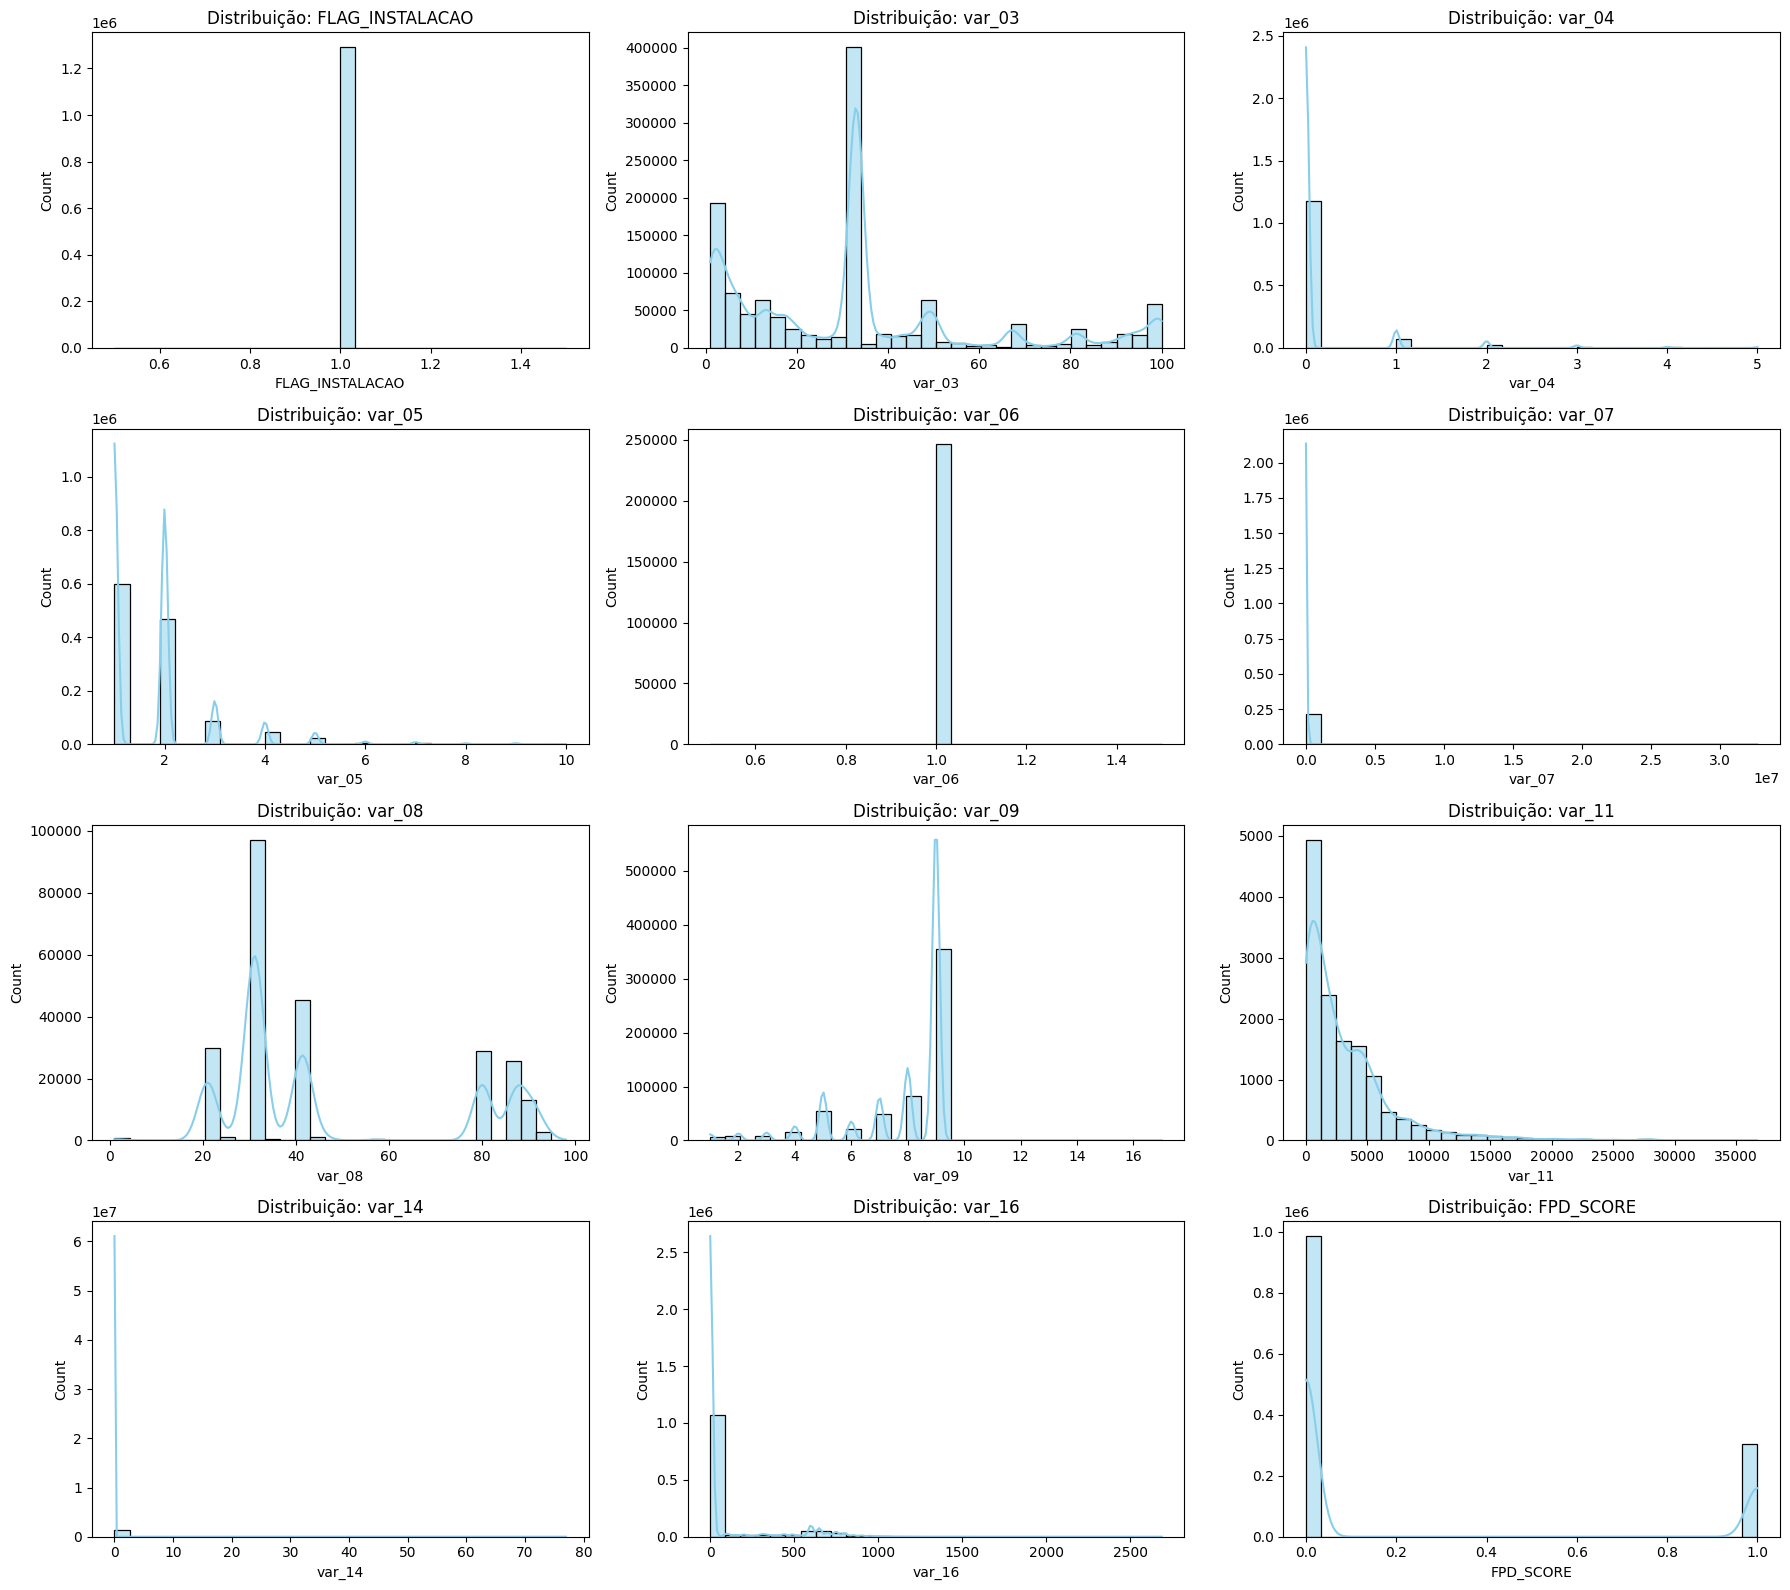

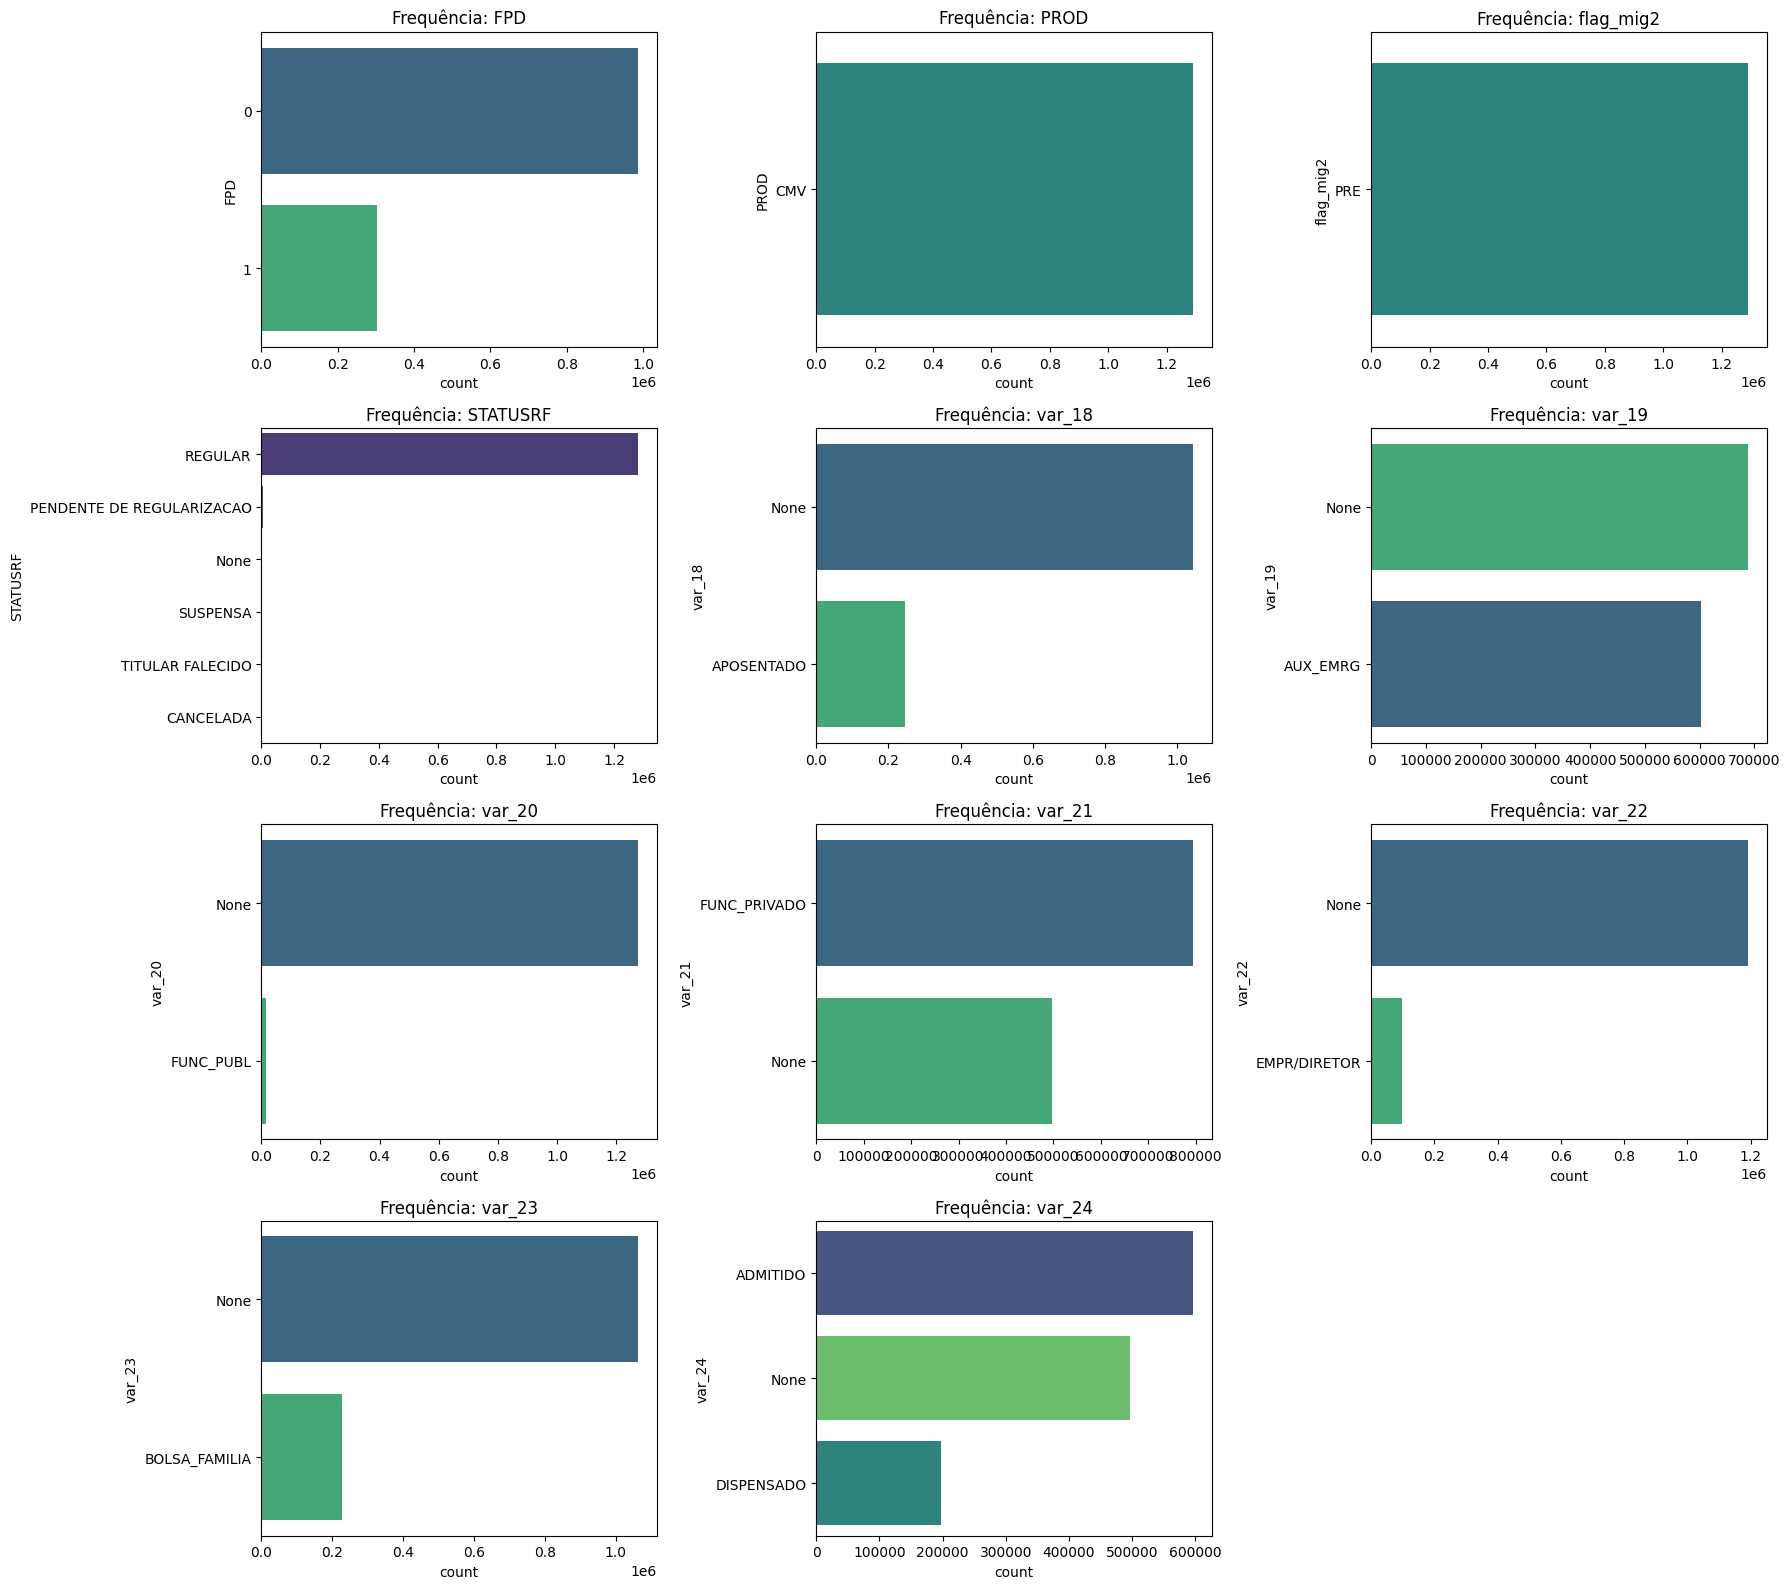

In [59]:
#  Alterando FPD para fazer sentido na análise gráfica
df_bdc_alt['FPD'] = df_bdc_alt['FPD'].astype('category')

# Identificando colunas por tipo (exceto as datas que exigem tratamento especial)
cols_num = df_bdc_alt.select_dtypes(include=['float64', 'int64']).columns.tolist()
cols_cat = df_bdc_alt.select_dtypes(include=['object', 'category']).columns.tolist()


# --- PARTE 1: VARIÁVEIS NUMÉRICAS (Histogramas) ---
n_cols = 3
n_rows = math.ceil(len(cols_num) / n_cols)

plt.figure(figsize=(18, 4 * n_rows))
for i, col in enumerate(cols_num, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df_bdc_alt[col].dropna(), kde=True, bins=30, color='skyblue')
    plt.title(f'Distribuição: {col}')
plt.tight_layout()
plt.show()

# --- PARTE 2: VARIÁVEIS CATEGÓRICAS (Barras) ---
# Filtramos apenas as categorias com cardinalidade razoável para o gráfico não travar
cols_cat_plot = [c for c in cols_cat if df_bdc_alt[c].nunique() < 20]

n_rows_cat = math.ceil(len(cols_cat_plot) / n_cols)
plt.figure(figsize=(18, 4 * n_rows_cat))
for i, col in enumerate(cols_cat_plot, 1):
    plt.subplot(n_rows_cat, n_cols, i)
    # Mostra os top valores
    order = df_bdc_alt[col].value_counts().index
    sns.countplot(data=df_bdc_alt, y=col, order=order, palette='viridis', hue=col, legend=False)
    plt.title(f'Frequência: {col}')
plt.tight_layout()
plt.show()

## Colunas Numéricas:

###Insights Variáveis Numéricas (I.A):


**FLAG_INSTALACAO e var_06:**

 São colunas estáticas, onde todos os registros possuem o valor 1,0.






**var_03, var_05 e var_08:**

Apresentam distribuições multimodais (vários picos). Isso é muito comum em scores ou ratings, onde o sistema "agrupa" clientes em faixas específicas.

**Nota sobre var_08:**

 O histograma mostra picos claros em torno de 30, 40 e 80. Ela tem uma dispersão saudável para análise.

**var_04, var_07, var_14 e var_16:**

 São variáveis com altíssima assimetria à direita (Long Tail). A grande massa de dados está perto de zero, mas existem outliers extremos (como os 30 milhões na var_07).

**Ação:**

 Para modelos lineares, essas variáveis precisarão de transformação (como Log ou Capping), mas para árvores de decisão (XGBoost/LightGBM), elas podem ser usadas como estão.

**O Alvo: FPD_SCORE**


O gráfico do FPD_SCORE mostra que a maioria da base tem score próximo a 0, com uma pequena parcela concentrada em 1. Isso indica que você está trabalhando com uma base onde o evento de inadimplência é minoritário (desbalanceado), o que é o padrão em crédito.

##Colunas Categóricas

###Insights Variáveis Categóricas (I.A):

1. **Variáveis de Baixa Variância (Candidatas a Exclusão)**


**PROD e flag_mig2:** Apresentam um único valor dominante (Constantes). Variáveis que não variam não possuem poder preditivo e serão removidas para simplificar o modelo.

**STATUSRF:** Cerca de 99% da base está classificada como "REGULAR". Embora seja um dado oficial, a baixíssima representatividade de outras classes (Suspensa, Cancelada) pode torná-la irrelevante para a diferenciação de risco nesta amostra específica.

2. **Qualidade de Preenchimento e Dados Ausentes (None)**

**Dominância de Nulos:**

As variáveis var_18, var_20, var_21, var_22 e var_23 têm o valor "None" como categoria majoritária.

**Ocupação e Perfil:**

 Estas colunas parecem descrever o vínculo empregatício ou a origem da renda (ex: Aposentado, Funcionário Privado). A alta concentração de "None" sugere que essa informação é coletada apenas para um subgrupo de clientes ou em canais de venda específicos.

3. **Variáveis com Potencial Discriminatório**


**var_15 e var_24:** Apresentam uma distribuição mais heterogênea entre as categorias (ex: "Admitido", "Dispensado"). Por possuírem maior "contraste" entre as classes, são fortes candidatas a explicar variações no FPD durante a análise bivariada.

**CEP_3_digitos:** Possui alta cardinalidade (902 valores). Embora não tenha sido plotada para evitar poluição visual, sua análise pode ser feita via agrupamento regional para identificar bolsões de inadimplência geográfica.

**Conclusão da Etapa**

"O dataset categórico é marcado por uma forte concentração de valores nulos ou categorias únicas. O desafio da modelagem será extrair valor das variáveis de perfil (var_15 a var_24) mesmo com o desbalanceamento observado."

## Colunas Temporais

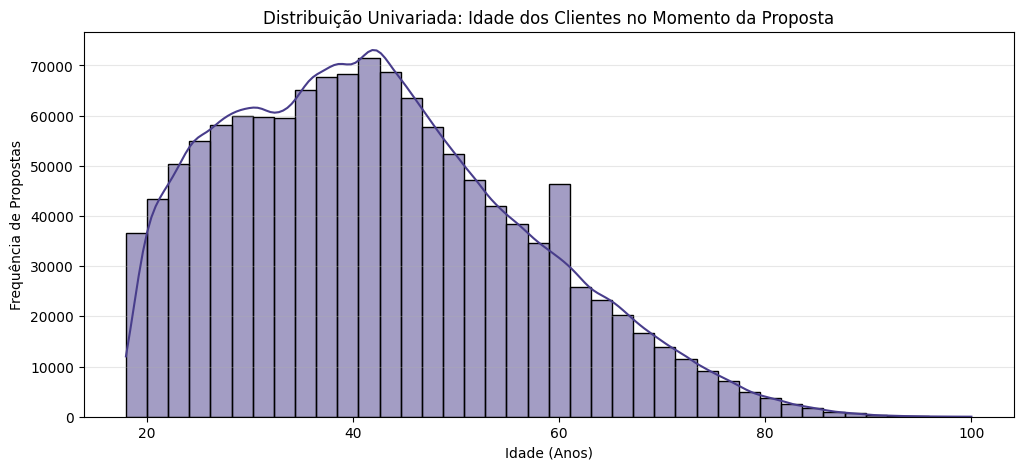

Resumo estatístico da Idade:
count   1288300.00
mean         42.41
std          14.28
min          18.00
25%          31.00
50%          41.00
75%          52.00
max         100.00
Name: idade, dtype: float64


In [60]:
# 1. Calculando a idade exata baseada na data da proposta (SAFRA)
# Subtraímos as datas e dividimos por 365.25 para considerar anos bissextos
df_bdc_alt['idade'] = ((df_bdc_alt['SAFRA'] - df_bdc_alt['DATADENASCIMENTO']).dt.days / 365.25).apply(np.floor)

# 2. Limpeza de anomalias (Idades impossíveis para crédito)
# Clientes com idade negativa ou acima de 100 anos costumam ser erros de digitação
df_bdc_alt.loc[(df_bdc_alt['idade'] < 18) | (df_bdc_alt['idade'] > 100), 'idade'] = np.nan

# 3. Plotando a Análise Univariada da Idade
plt.figure(figsize=(12, 5))
sns.histplot(df_bdc_alt['idade'].dropna(), bins=40, kde=True, color='darkslateblue')

plt.title('Distribuição Univariada: Idade dos Clientes no Momento da Proposta')
plt.xlabel('Idade (Anos)')
plt.ylabel('Frequência de Propostas')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Exibindo estatísticas descritivas
print("Resumo estatístico da Idade:")
print(df_bdc_alt['idade'].describe())

### Insights Colunas Temporais(I.A):


O cálculo da idade utilizando a diferença entre a SAFRA (data da proposta) e a DATADENASCIMENTO permitiu identificar o perfil etário real no momento da tomada de decisão de crédito.

**Pico de Solicitações:**

 A maior concentração de clientes está na faixa dos 35 aos 45 anos, com o ápice em torno dos 42 anos, onde o volume ultrapassa 70.000 propostas por faixa etária.

**Perfil Jovem:**

 Existe um volume significativo de novos proponentes logo no início da vida financeira, entre 18 e 25 anos, totalizando cerca de 35.000 a 50.000 propostas por idade nesta faixa.

**Anomalia nos 60 anos:**

 Observa-se um "degrau" ou pico atípico exatamente aos 60 anos. Isso pode indicar um público específico de aposentados e pensionistas que entram na base através de produtos nichados (como consignado) ou um comportamento de arredondamento de datas em sistemas legados.

**Cauda Longa:** A base de clientes diminui de forma constante após os 65 anos, tornando-se muito escassa após os 80 anos, o que é esperado em modelos de crédito de consumo.

##Boxplots

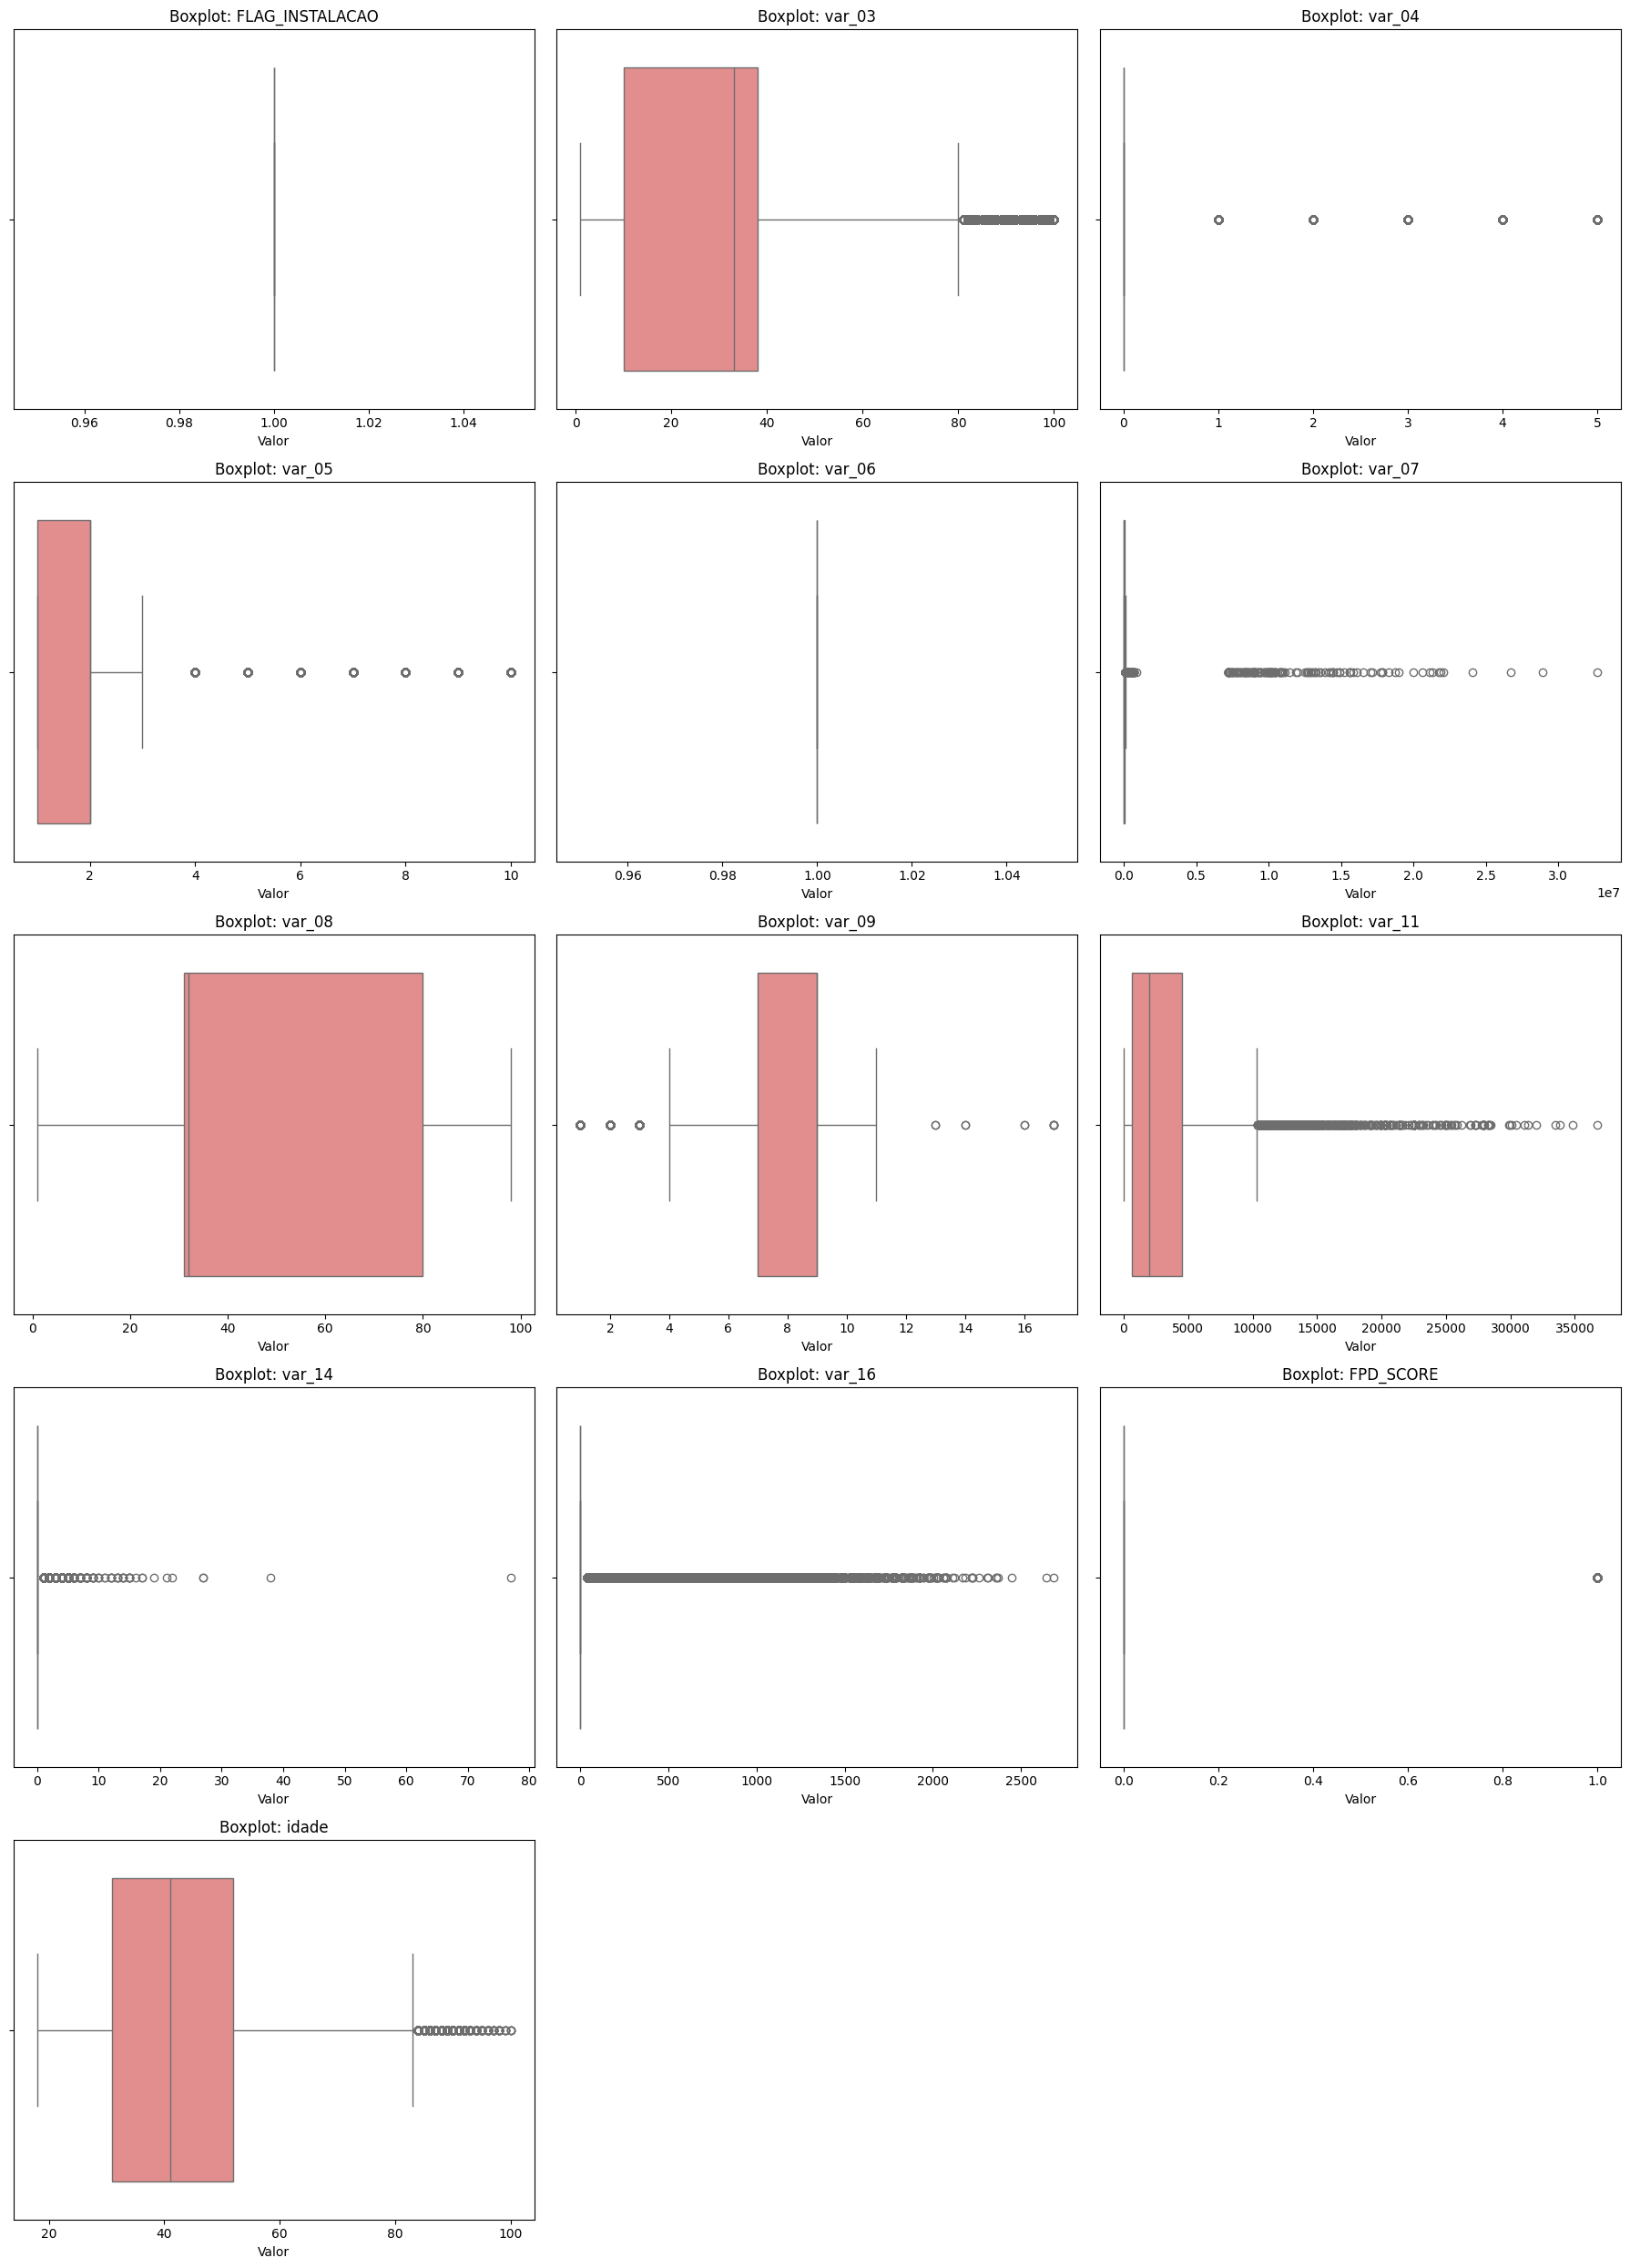

In [61]:

# Selecionando as colunas numéricas (exceto FPD e ID se ainda existirem)
cols_num = df_bdc_alt.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'FPD' in cols_num: cols_num.remove('FPD')

# Configurando o layout do grid
n_cols = 3
n_rows = math.ceil(len(cols_num) / n_cols)

plt.figure(figsize=(18, 5 * n_rows))

for i, col in enumerate(cols_num, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=df_bdc_alt[col], color='lightcoral')
    plt.title(f'Boxplot: {col}')
    plt.xlabel('Valor')

plt.tight_layout()
plt.show()

## Insights Boxplots (I.A):

###
1. **Variáveis com Outliers Críticos**

    **var_07:**

    É o caso mais extremo. A "caixa" está totalmente esmagada no zero, com uma linha de outliers que se estende até 30 milhões. Isso indica uma variável financeira (como renda ou limite) com pouquíssimos valores astronômicos que distorcem a média.

    **var_11 e var_16:**

    Ambas apresentam uma densa nuvem de outliers à direita. Embora a maioria dos dados esteja concentrada em valores baixos, a quantidade de pontos fora das hastes sugere que esses valores "altos" são comuns e podem carregar um padrão de risco importante.

    **var_14:**

    Apresenta alguns outliers isolados, incluindo um valor próximo a 80, enquanto a massa de dados está próxima de zero.

2. **Variáveis de Distribuição Ampla (Sem Outliers Excessivos)**


    **var_03, var_08 e idade:**

    Estas variáveis possuem "caixas" bem definidas, indicando uma boa distribuição dos dados entre os quartis.

    **Idade:**

    A mediana está em torno de 42 anos, com outliers apenas após os 85 anos.

    **var_08:**

    Curiosamente, não apresenta outliers, ocupando quase todo o espectro de 0 a 100, o que reforça que ela é uma variável de score ou índice bem distribuída.

3.  **Variáveis Constantes ou Binárias**

    **FLAG_INSTALACAO e var_06:**

    Aparecem apenas como uma linha vertical no valor 1.0. Não há variação, portanto, não há caixa nem outliers. Confirmado: podem ser removidas.



# Análise Bivariada Comparando o Impacto das Variáveis no Target

##Insights Variáveis Numéricas (I.A):




/tmp/ipython-input-1866227392.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_plot, x=col, hue=target, fill=True, common_norm=False)


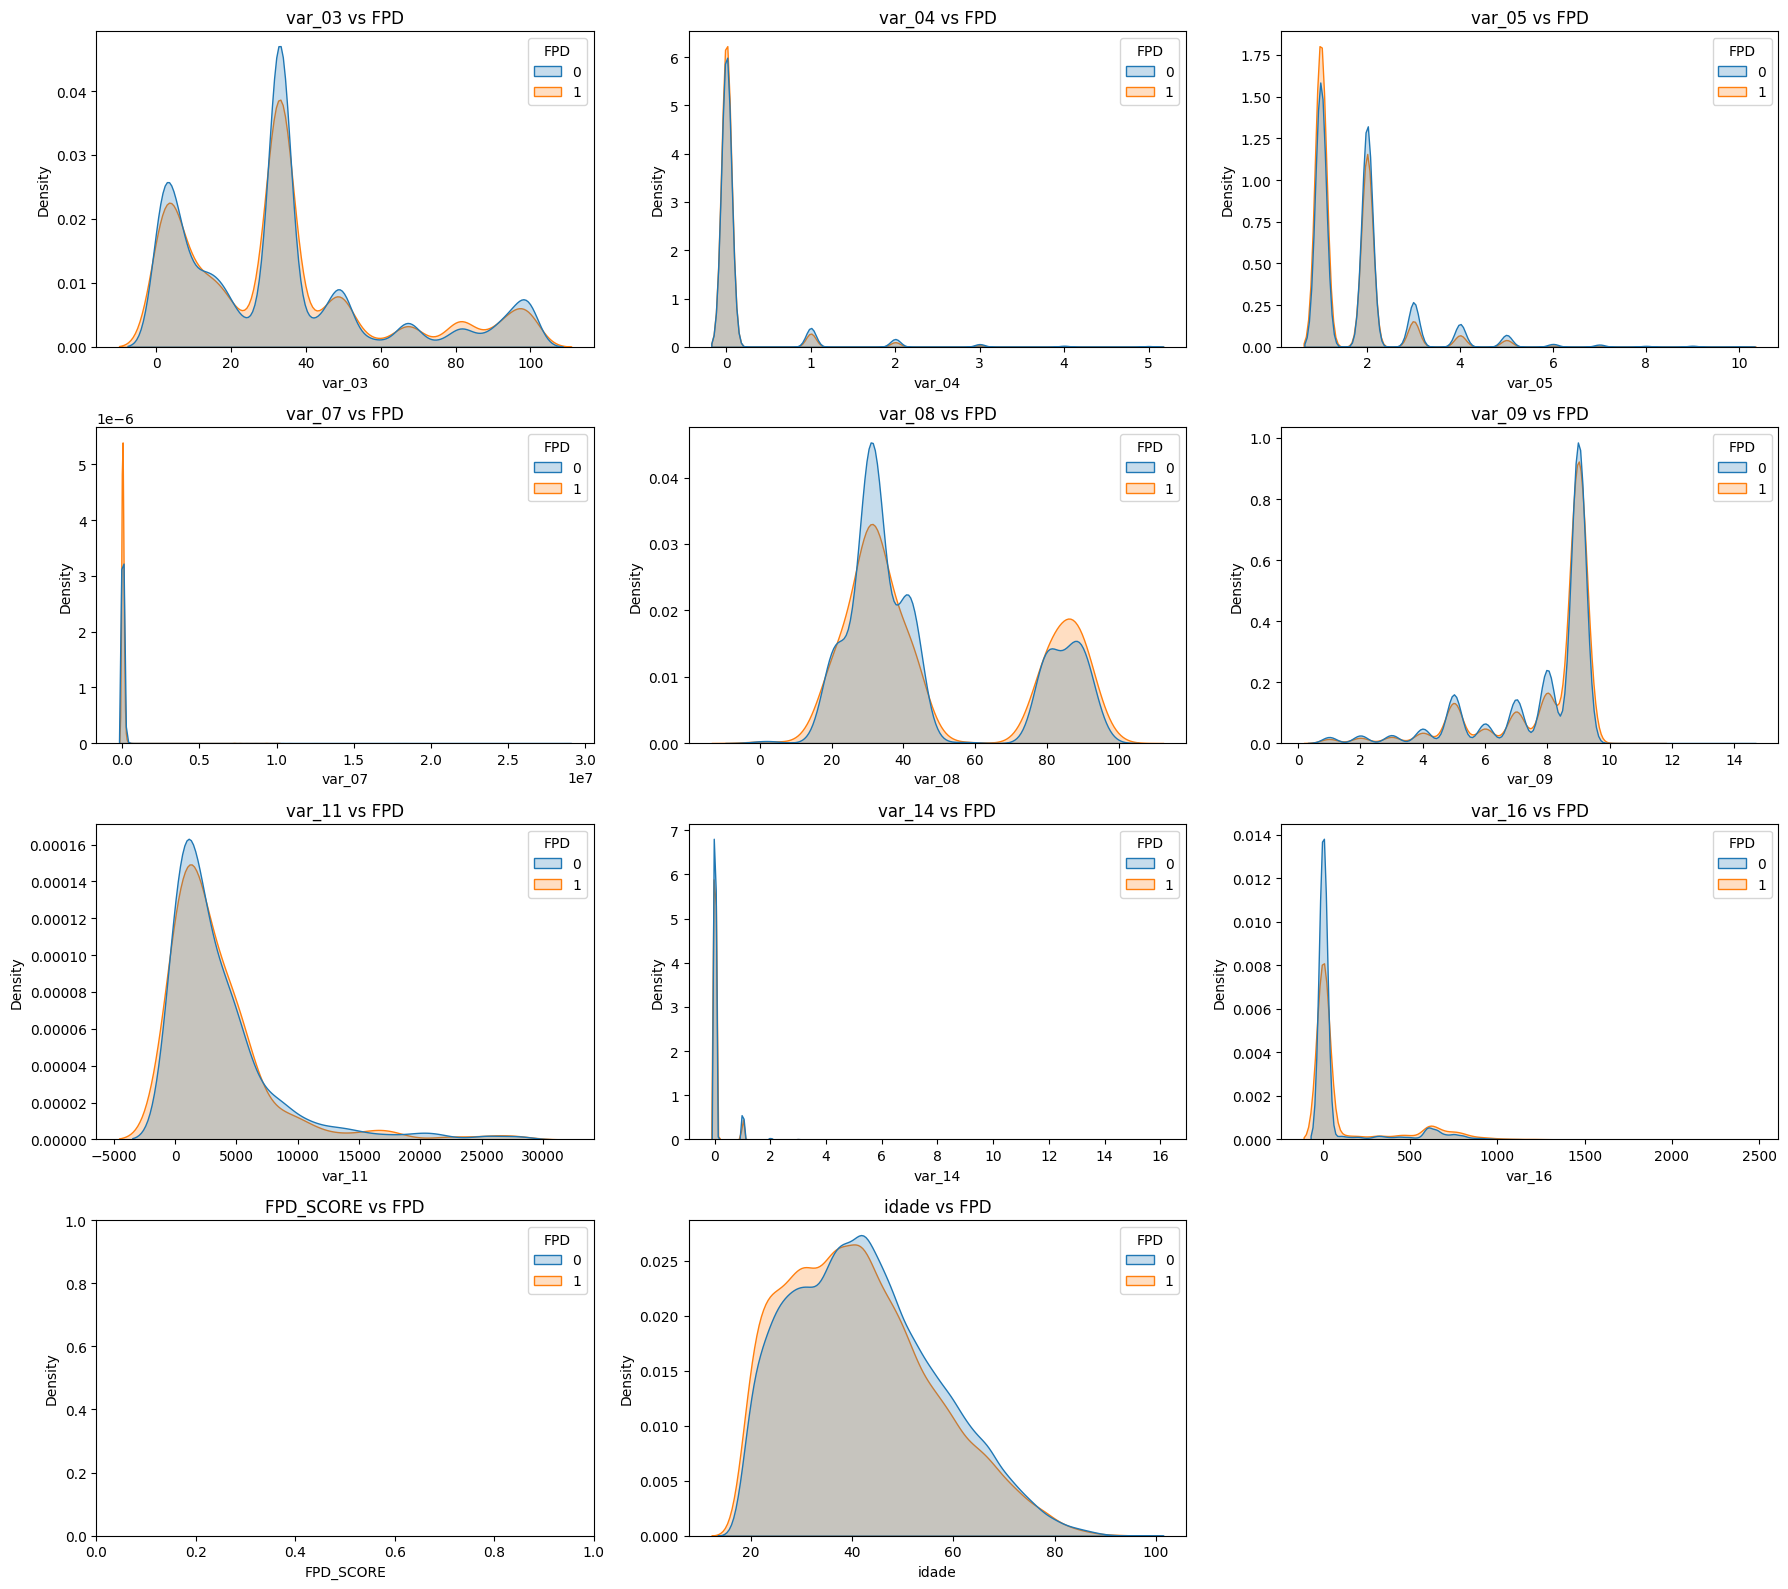

In [62]:
kdeplots_var_num_target(df_bdc_alt, 'FPD')
plt.show()

###
1. **Variáveis com Alto Poder Preditivo (Sinal Forte)**


**var_08:**

 É possivelmente sua melhor variável numérica. Note que a curva de FPD 1 (Laranja) é visivelmente mais alta no pico à direita (próximo a 80-90) em comparação com a curva de FPD 0 (Azul). Isso indica que valores altos nesta variável estão fortemente correlacionados com a inadimplência.

**idade:**

 Existe um deslocamento sutil, mas importante. A densidade de FPD 1 é maior entre os 20 e 35 anos, enquanto a densidade de FPD 0 começa a dominar a partir dos 45-50 anos. Isso confirma que proponentes mais jovens possuem um risco relativo mais elevado nesta base.

**var_03:**

 Apresenta picos distintos. O comportamento do FPD muda conforme o "degrau" da variável, sugerindo que ela pode ser usada para criar faixas de risco (bins).

2. **Variáveis de Baixo Contraste (Sinal Fraco/Ruído)**

**var_04, var_07 e var_14:**

 As curvas azul e laranja estão praticamente sobrepostas. Isso significa que, independentemente do valor ser 0 ou 10 milhões, a probabilidade de FPD permanece quase a mesma.

**Atenção:** O "esmagamento" devido aos outliers pode estar escondendo o sinal. Recomenda-se testar essas variáveis com escala logarítmica futuramente.

**var_11 e var_16:**

 Ambas mostram uma leve tendência de FPD 1 em valores muito baixos, mas a sobreposição é muito alta para serem preditores isolados fortes.

##Insights Variáveis Categóricas(I.A):

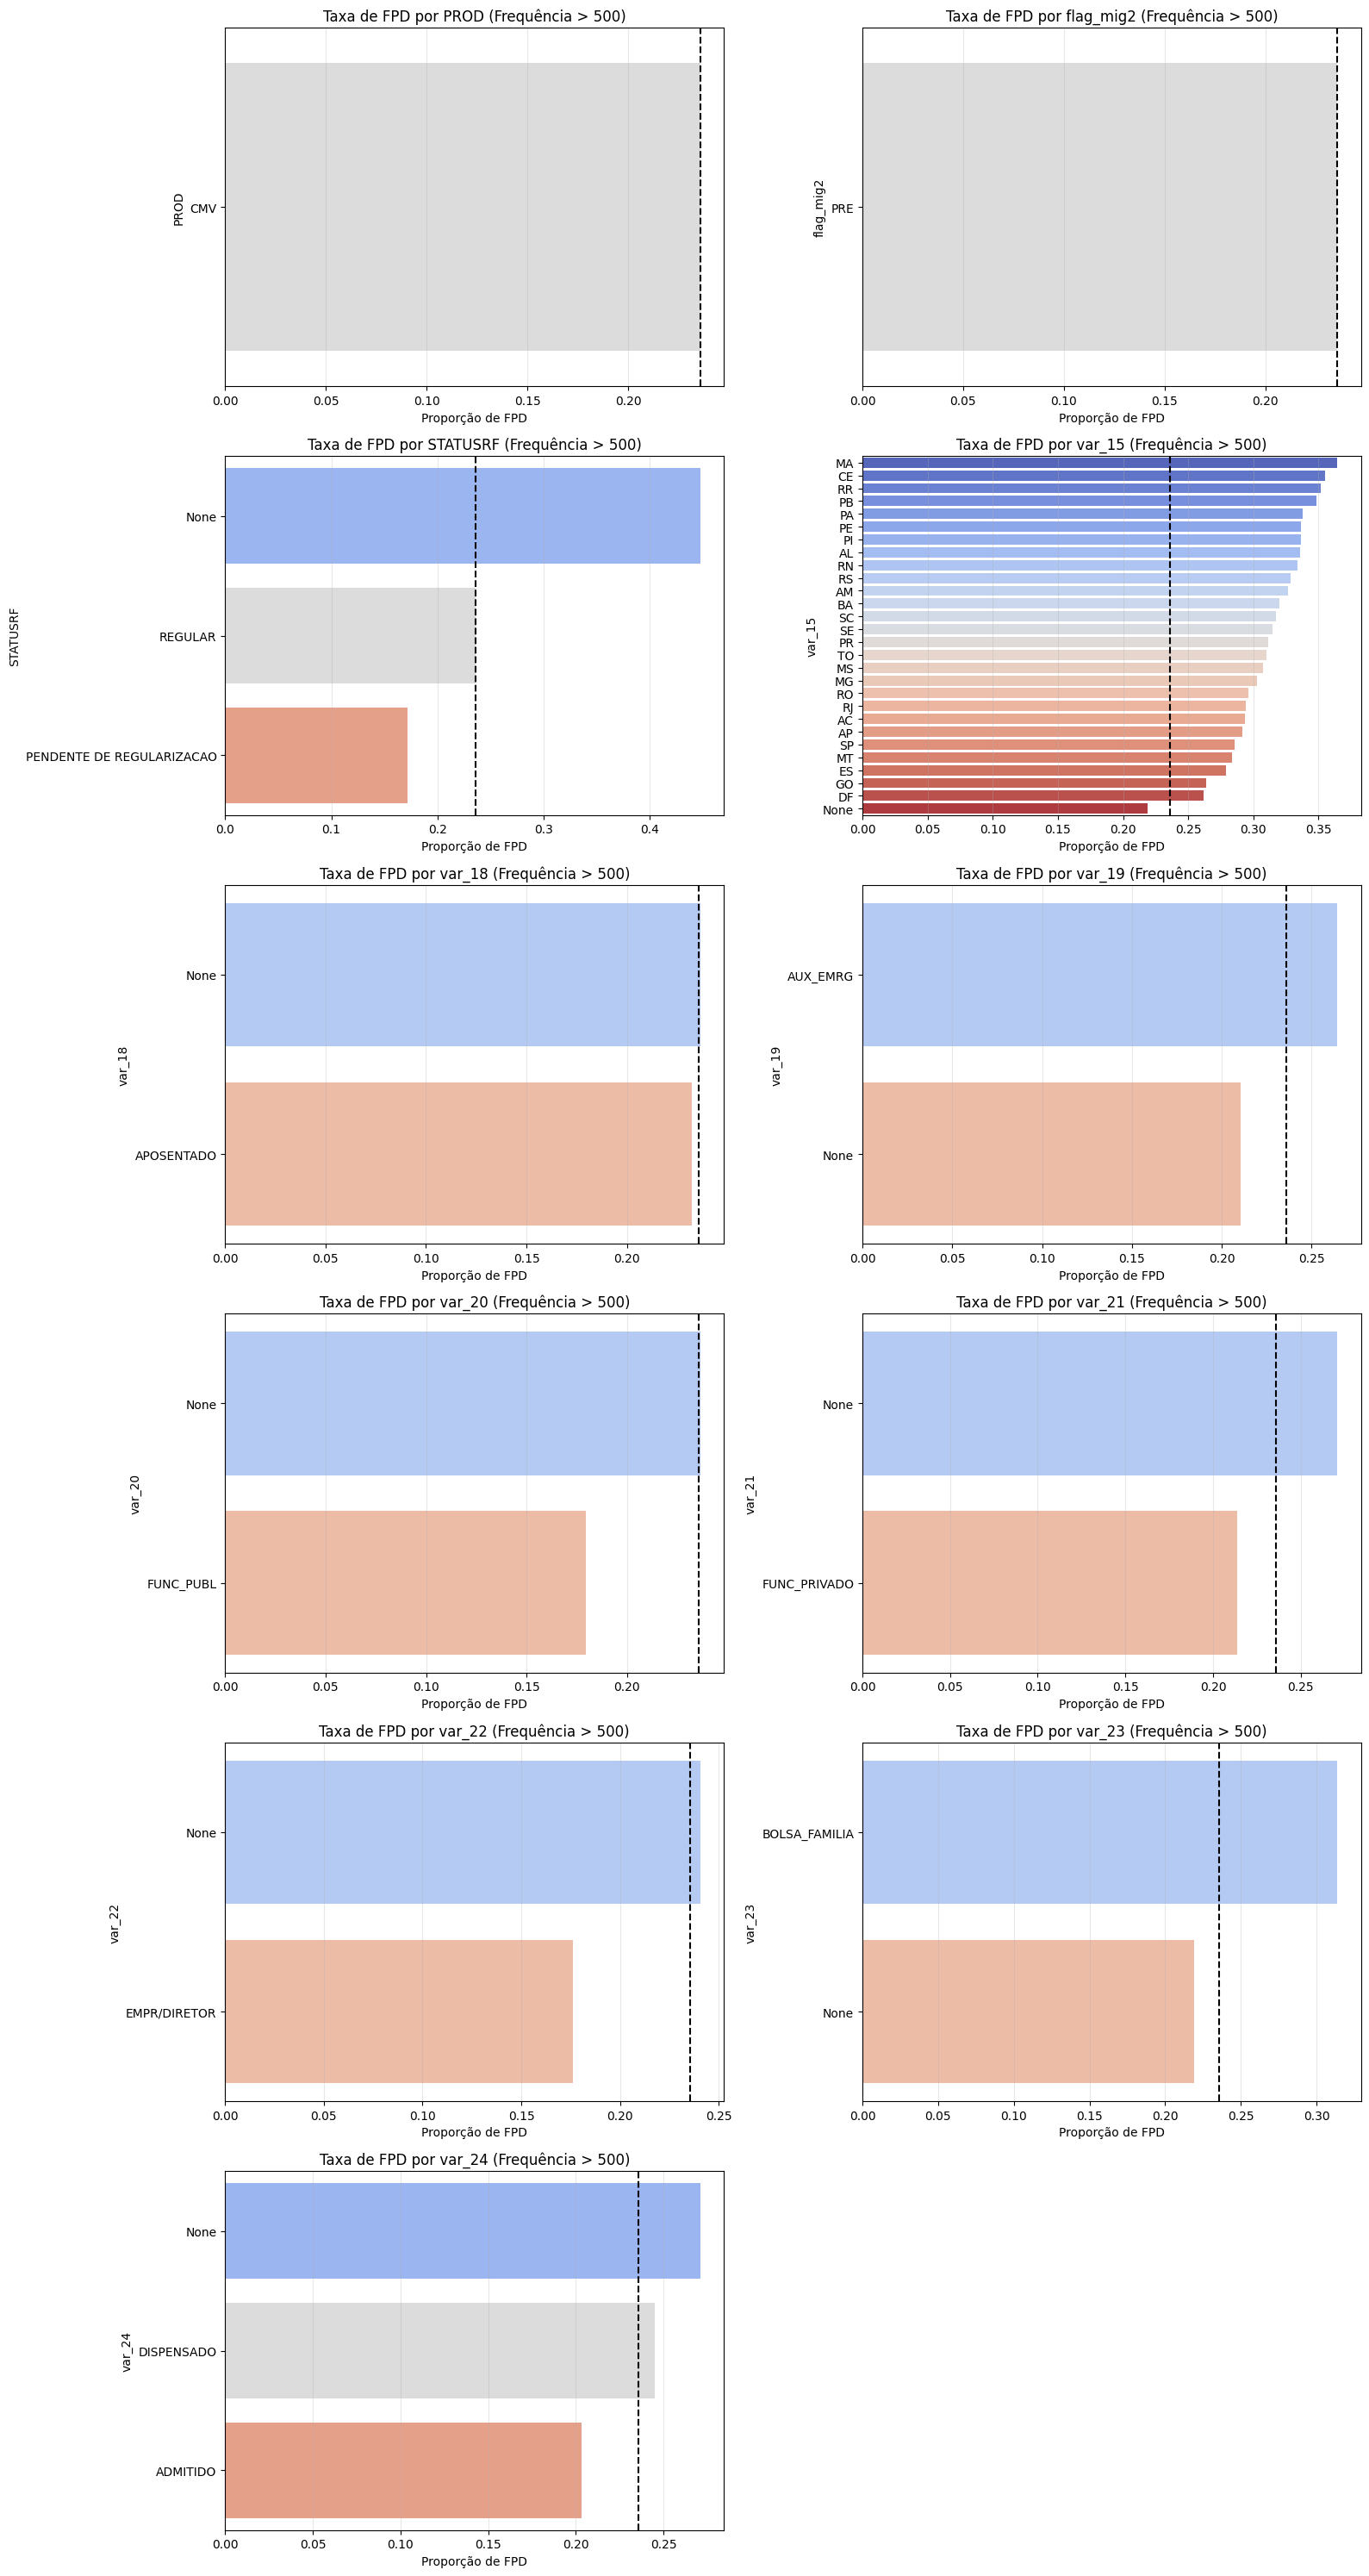

In [63]:

plot_cat_vs_target_percentage(df_bdc_alt, 'FPD', cutoff=500)
plt.show()

###Insights da Análise Bivariada Categórica(I.A)


**A linha tracejada preta nos gráficos representa a Média Geral de FPD da base (aprox. 23.5%). Categorias cujas barras ultrapassam essa linha são grupos de risco superior à média.**


1. **O Impacto Geográfico (var_15)**

    **Destaque Negativo:** Estados como MA, CE e RR apresentam as maiores taxas de inadimplência, chegando a quase 35%. Isso é cerca de 12 pontos percentuais acima da média geral.

    **Destaque Positivo:** O DF (Distrito Federal) e registros classificados como None nesta variável apresentam o menor risco relativo.



2. **Perfil de Vínculo e Renda (var_24, var_21, var_20)**


    **var_24 (Status de Emprego):** Clientes com status None (informação ausente) têm risco maior que a média. Já os ADMITIDO são os melhores pagadores deste grupo.

    **Servidores e Funcionários:** Em var_20 (FUNC_PUBL) e var_21 (FUNC_PRIVADO), os clientes identificados com esses vínculos possuem uma taxa de FPD menor que a média geral, confirmando que estabilidade empregatícia reduz o risco.

    **Bolsa Família (var_23):** O grupo identificado com este benefício apresenta um risco ligeiramente superior à média da base.

3. **Informações Ausentes (None) como Sinal de Risco**
    Em quase todas as variáveis (STATUSRF, var_18, var_22, var_24), quando o valor é None, a taxa de FPD tende a ser maior que a média.

    **Insight de Crédito:** A ausência de dados (atrito no preenchimento ou falta de rastro burocrático) é, por si só, um forte indicador de risco nesta base

##Insights Variáveis Temporais(I.A)

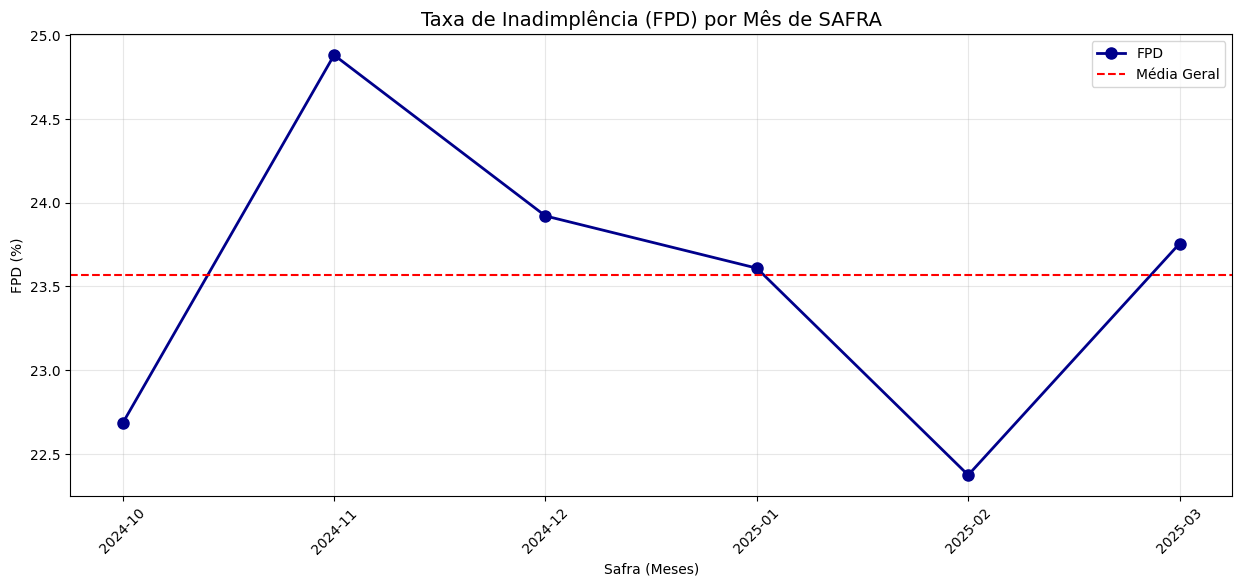

In [64]:

analise_bivariada_temporal(df_bdc_alt, 'SAFRA', 'FPD')

1. **Estabilidade da Safra (SAFRA vs FPD)**

    **O gráfico de linha revela a evolução da inadimplência real ao longo do tempo:**


    **Volatilidade Controlada:**
    
    A taxa de FPD flutua entre 22,3% e 24,9%. Embora haja variação, ela ocorre dentro de um intervalo de aproximadamente 2,6 pontos percentuais, indicando uma carteira relativamente estável.

    **Pico de Risco (Nov/2024):**
    
    Houve um aumento nítido na inadimplência em 2024-11, atingindo o ponto máximo da série.

    **Recuperação e Tendência Atual:**
    
     Após o pico, o risco caiu consistentemente até fevereiro de 2025, com uma leve subida em março de 2025. A média geral (linha tracejada vermelha) serve como âncora para identificar que as safras mais recentes estão operando próximas ou abaixo da média histórica.

2. **Cruzamentos com outras Temporais**


    **Idade na Safra:**

    Como vimos na bivariada numérica, a idade calculada no momento da SAFRA mostra que o risco é maior para clientes mais jovens, estabilizando-se após os 40 anos.

    **Datas de Eventos (var_12, var_13):**
    
     Devido à alta taxa de nulos ou preenchimento específico, estas datas devem ser tratadas como variáveis de "Recência" (ex: dias desde o último evento) em vez de datas absolutas para a modelagem.

#Dicionário de Dados

In [65]:

variaveis = [
    "NUM_CPF", "SAFRA", "FLAG_INSTALACAO", "FPD", "PROD", "flag_mig2",
    "STATUSRF", "DATADENASCIMENTO", "var_03", "var_02", "var_04", "var_05",
    "var_06", "var_07", "var_08", "var_09", "var_10", "var_11", "var_12",
    "var_13", "var_14", "var_15", "var_16", "var_17", "var_18", "var_19",
    "var_20", "var_21", "var_22", "var_23", "var_24", "var_25", "CEP_3_digitos"

]

tipos_sugeridos = [
    "object", "datetime64", "int64", "category", "object", "object",
    "object", "datetime64", "float64", "object", "float64", "float64",
    "float64", "float64", "float64", "float64", "object", "float64",
    "datetime64", "datetime64", "int64", "object", "int64",
    "object", "object", "object", "object", "object", "object",
    "object", "object", "object", "object"
]

descricoes = [
    "CPF do cliente (ID anonimizado)", "Mês de concessão do crédito", "Indicador de instalação",
    "Target: 1=Inadimplente, 0=Em dia", "Tipo de produto", "Flag de migração",
    "Status na Receita Federal", "Data de nascimento", "Variável numérica anonimizada",
    "Categórica com muitos nulos", "Variável numérica anonimizada", "Variável numérica anonimizada",
    "Numérica com poucos dados", "Numérica com outliers extremos", "Score/Índice de 0 a 100",
    "Variável numérica anonimizada", "Variável categórica anonimizada", "Baixíssimo preenchimento",
    "Data de atualização cadastral", "Data de evento anonimizada", "Código numérico discreto",
    "Provável UF/Região", "Variável numérica discreta", "Variável 100% nula",
    "Categórica anonimizada", "Categórica anonimizada", "Vínculo setor público",
    "Vínculo setor privado", "Categórica anonimizada", "Programas sociais/benefícios",
    "Status de ocupação/emprego", "Categórica anonimizada", "Região (3 dígitos do CEP)",

]

# 2. Montamos o DataFrame do Dicionário

df_dicionario = pd.DataFrame({
    'Nome da Variável': variaveis,
    'Tipo de Dado Atual': ['object'] * 33,
    'Tipo de Dado Sugerido': tipos_sugeridos,
    'Descrição': descricoes
})

# 3. Exibimos a tabela formatada (isso é rápido porque não processa o 1.2M de linhas)
df_dicionario.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    dict(selector='th', props=[('background-color', '#2c3e50'), ('color', 'white')])
])

,Nome da Variável,Tipo de Dado Atual,Tipo de Dado Sugerido,Descrição
0,NUM_CPF,object,object,CPF do cliente (ID anonimizado)
1,SAFRA,object,datetime64,Mês de concessão do crédito
2,FLAG_INSTALACAO,object,int64,Indicador de instalação
3,FPD,object,category,"Target: 1=Inadimplente, 0=Em dia"
4,PROD,object,object,Tipo de produto
5,flag_mig2,object,object,Flag de migração
6,STATUSRF,object,object,Status na Receita Federal
7,DATADENASCIMENTO,object,datetime64,Data de nascimento
8,var_03,object,float64,Variável numérica anonimizada
9,var_02,object,object,Categórica com muitos nulos


In [66]:
df_base_dados_cadastrais.nunique()

,0
NUM_CPF,3590459
SAFRA,6
FLAG_INSTALACAO,2
FPD,2
PROD,3
flag_mig2,3
STATUSRF,6
DATADENASCIMENTO,30046
var_03,100
var_02,2130
